# Artificial Neural Networks and Deep Learning - Homework 2

| Overfitters del test set    | PoliMi ID |
|:----------------------------|:---------:|
|Pertino Paolo                | 10729600  |
|Sandri Alberto               | 10698469  |
|Simionato Enrico             | 10698193  |

In the second homework of the Artificial Neural Networks and Deep Learning course, a time series forecasting is proposed. The goal is to predict future samples of the input time series.

## 0. Preliminary operations

In the following section some preliminary operations in order to setup the environment correctly are performed.

### 0.1 Connect to Drive

In [1]:
try:
    from google.colab import drive
    print("Code running on Google Colab... Conncecting to Google Drive...")
    drive.mount('/gdrive')
    %cd /gdrive/My Drive/[2023-2024] AN2DL/Homework 2
except:
    print("The code is not running on Google Colab...")

Code running on Google Colab... Conncecting to Google Drive...
Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Homework 2


### 0.2 Download and import Libraries

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install keras
!pip install tqdm
!pip install scikit-learn
!pip install tensorflow[and-cuda]
!pip install pandas
!pip install scipy
!pip install Cython
!pip install opencv-python
!pip install -U keras_cv
!pip install imbalanced-learn
!pip install lime

In [ ]:
!pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.7/586.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 48.5 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.6.4
    Uninstalling websocket-client-1.6.4:
      Successfully uninstalled websocket-client-1.6.4
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
try:
    import comet_ml
    from comet_ml import Experiment
    from comet_ml.integration.pytorch import log_model

    comet_ml.init(project_name='ANNDL-TS FORECASTING')
except:
    print("Comet-ML is not installed on this platform. Skipping the import...")

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
import warnings
import logging
import random
import gc
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

random.seed(seed)

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import matplotlib.pyplot as plt
import cv2
#import keras_tuner
np.random.seed(seed)

from scipy.signal import detrend
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import backend as K
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from IPython.display import Image
from itertools import product

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

path_to_models='models/'
path_to_data='data/'

2.15.0
Num GPUs Available: 1


In [ ]:
try:
    from lime import lime_image
except:
    print("Lime is not installed on this platform. Skipping the import...")

Lime is not installed on this platform. Skipping the import...


## 1. Dataset inspection

In this section the content of the dataset is inspected and the images are prepared for later analysis.

### 1.1 Loading the data

In [3]:
categories = np.load('data/categories.npy', allow_pickle=True)
training_data = np.load('data/training_data.npy', allow_pickle=True)
valid_periods = np.load('data/valid_periods.npy', allow_pickle=True)

categories.shape, training_data.shape, valid_periods.shape

((48000,), (48000, 2776), (48000, 2))

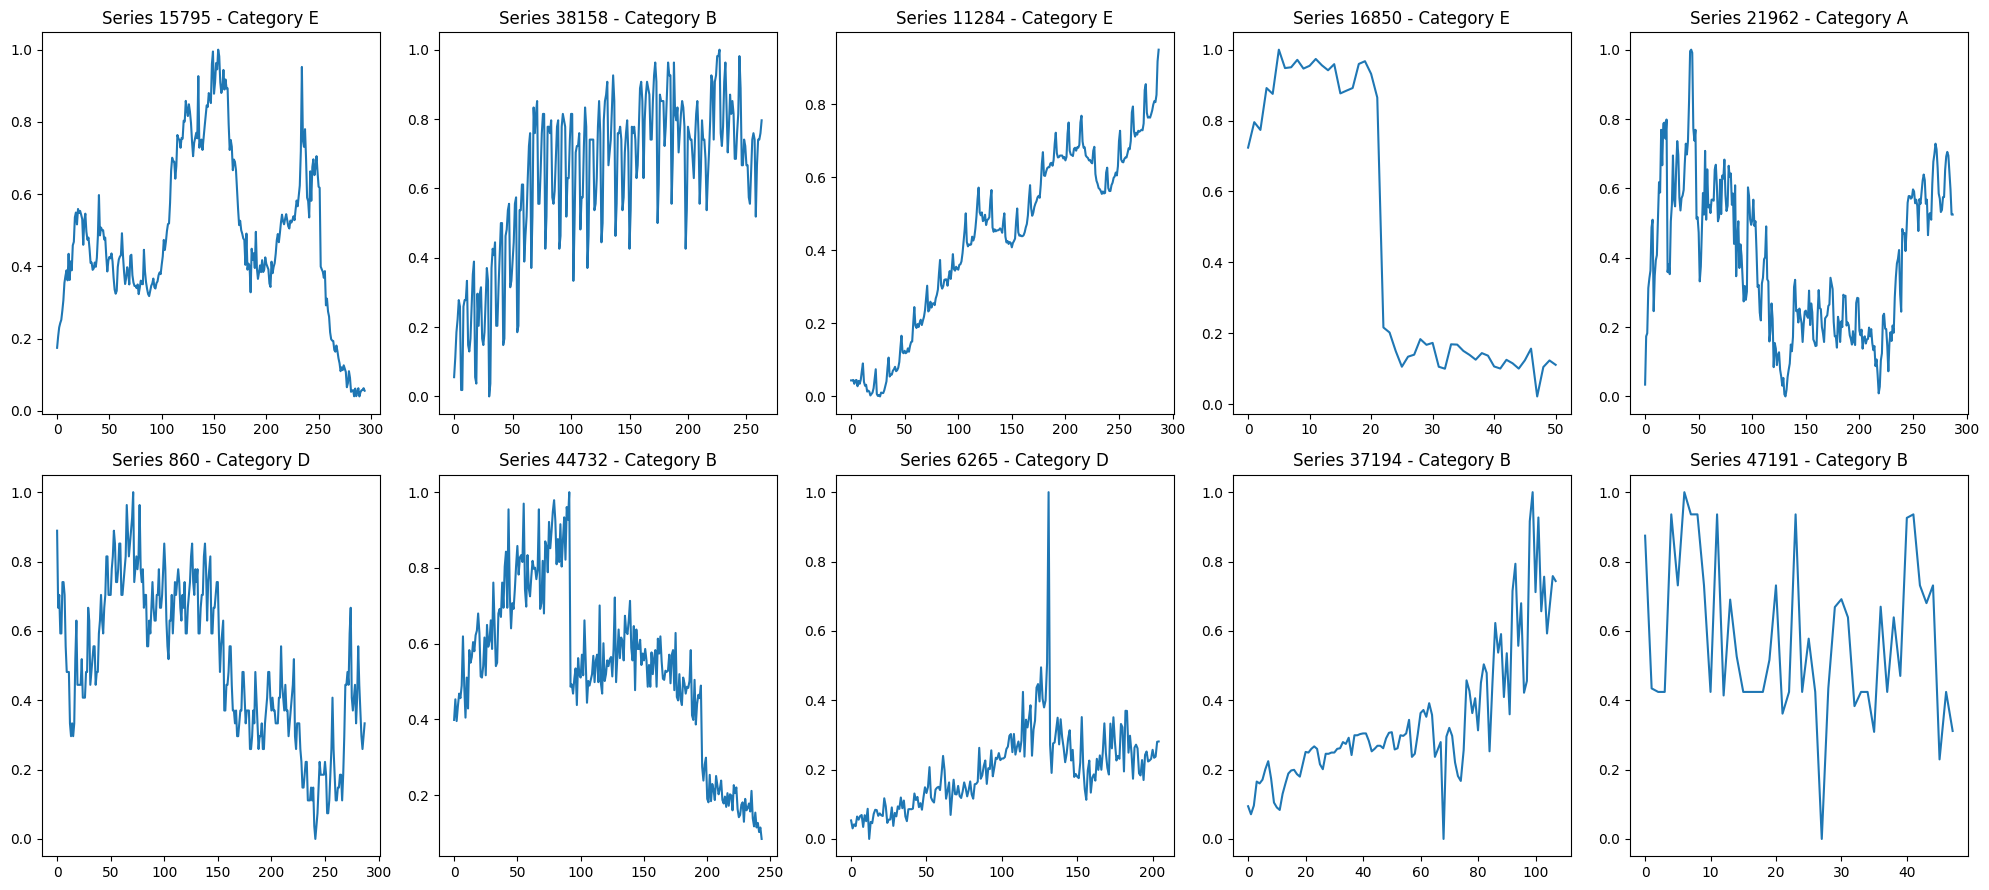

In [ ]:
num_series = 10

fig, axes = plt.subplots(2, num_series // 2, figsize=(20, 9))
for i in range(num_series):
    ax = axes[i % 2, i % num_series // 2]
    index_shown = np.random.randint(0, categories.shape[0])
    #index_shown = np.random.choice(np.where(categories == 'A')[0])
    ax.plot(training_data[index_shown, valid_periods[index_shown][0]:valid_periods[index_shown][1]], label = 'original')
    ax.legend()
    ax.set_title(f"Series {index_shown} - Category {categories[index_shown]}")
plt.tight_layout()
plt.show()

### 1.2 Outliers removal

Check for missing values like NaN or infinite.

In [ ]:
has_missing_values = np.isnan(training_data).any() or np.isinf(training_data).any()

if has_missing_values:
    print("The array contains missing values.")
else:
    print("The array does not contain missing values.")

The array does not contain missing values.


Finally let's check if there are duplicates and eventually remove them.

In [ ]:
# Combine the image data and labels into a single array
combined_data = np.c_[training_data, categories]

# Convert the combined data to a Pandas DataFrame
df = pd.DataFrame(training_data)

# Search for duplicates
duplicates = df.duplicated()

print(f'There are {sum(duplicates)} duplicates')

There are 26 duplicates


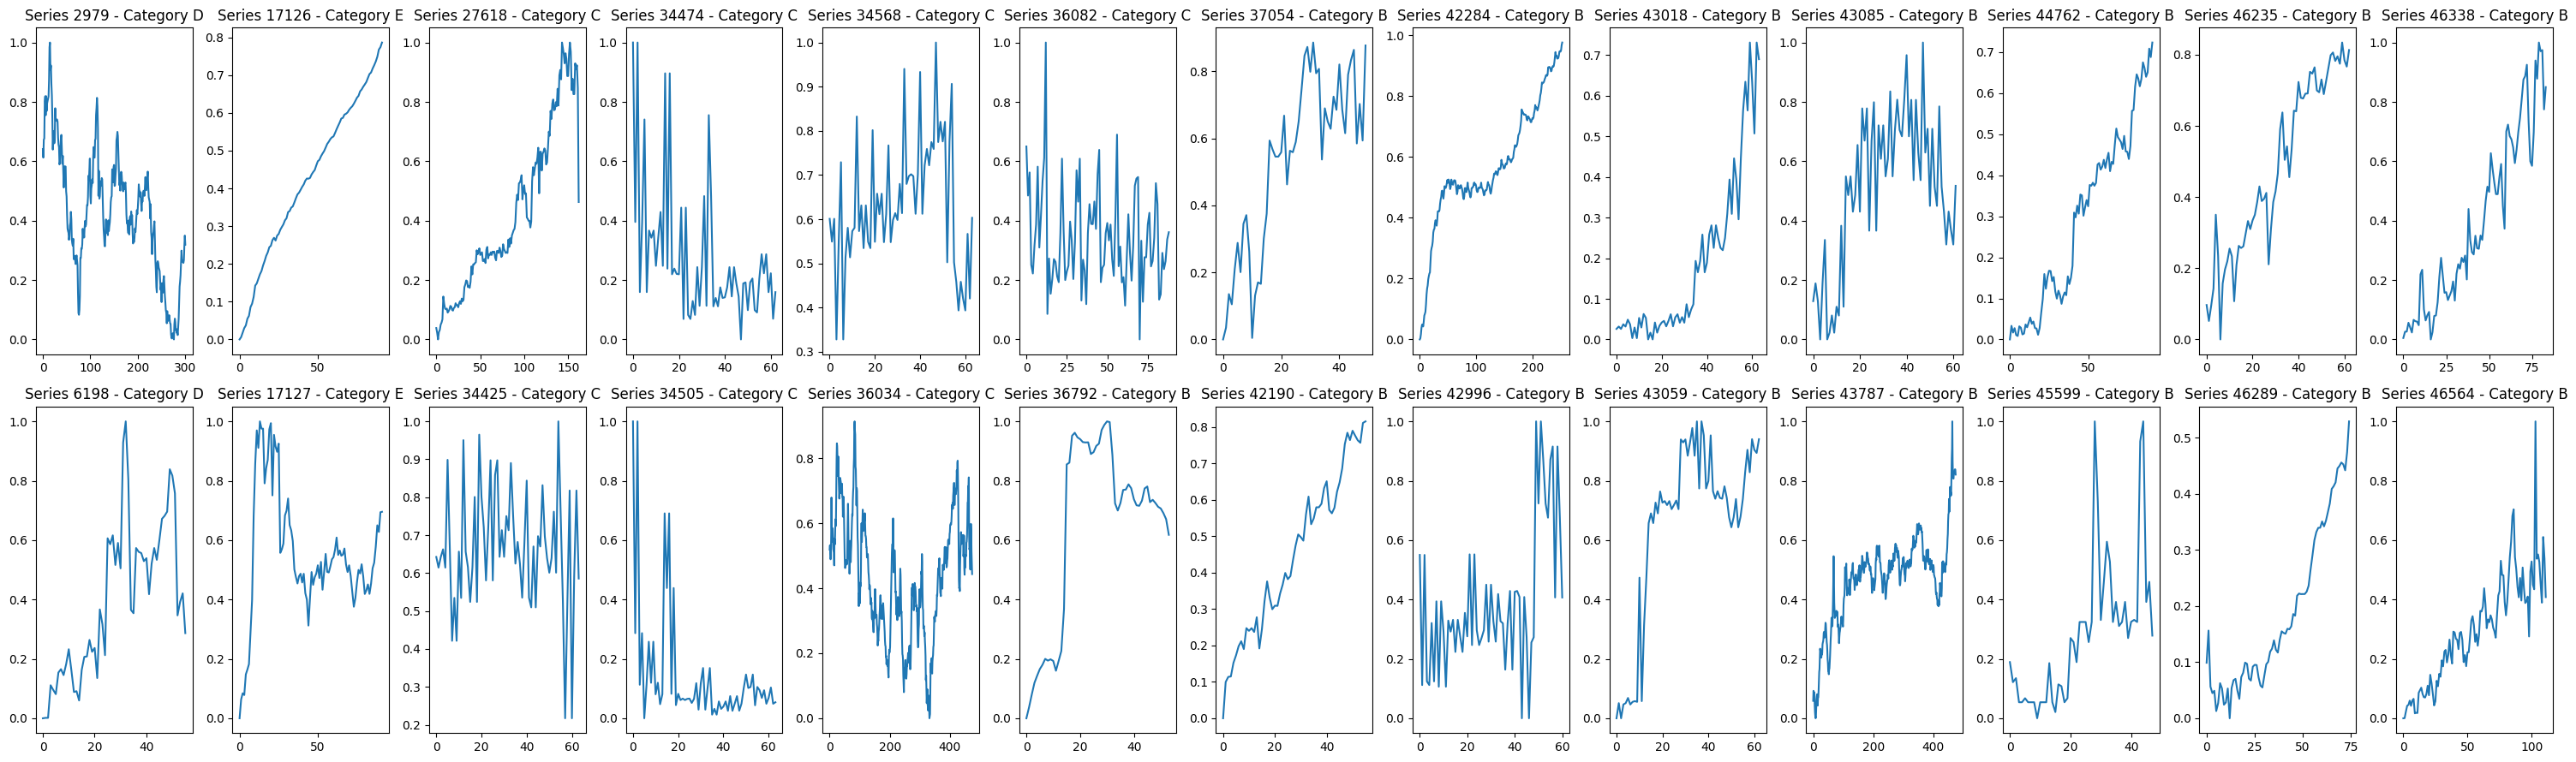

In [ ]:
# Find indexes of the duplicated time series
dup_idxs = np.where(duplicates == True)[0]
num_series = len(dup_idxs)

# Plot the duplicated time series
fig, axes = plt.subplots(2, num_series // 2, figsize=(30, 9))
for i, index_shown in enumerate(dup_idxs):
    ax = axes[i % 2, i % num_series // 2]
    ax.plot(training_data[index_shown, valid_periods[index_shown][0]:valid_periods[index_shown][1]])
    ax.set_title(f"Series {index_shown} - Category {categories[index_shown]}")
plt.tight_layout()
plt.show()

In [ ]:
print(f"Original datasets shape: categories {categories.shape}, training_data {training_data.shape}, valid_peiods {valid_periods.shape}")

# Create mask to eliminate the duplicates
duplicates = np.invert(duplicates.values)

# Eliminate the duplicates
categories = categories[duplicates]
training_data = training_data[duplicates]
valid_periods = valid_periods[duplicates]

print(f"Datasets shape after removing duplicates: categories {categories.shape}, training_data {training_data.shape}, valid_peiods {valid_periods.shape}")

Original datasets shape: categories (48000,), training_data (48000, 2776), valid_peiods (48000, 2)
Datasets shape after removing duplicates: categories (47974,), training_data (47974, 2776), valid_peiods (47974, 2)


### 1.3 Storing and loading the dataset without duplicates

In [ ]:
# Storing the dataset without duplicates
np.save('data/categories', categories, allow_pickle=True)
np.save('data/training_data', training_data, allow_pickle=True)
np.save('data/valid_periods', valid_periods, allow_pickle=True)

In [ ]:
categories = np.load('data/categories.npy', allow_pickle=True)
training_data = np.load('data/training_data.npy', allow_pickle=True).astype(np.float32)
valid_periods = np.load('data/valid_periods.npy', allow_pickle=True)

categories.shape, training_data.shape, valid_periods.shape

((47974,), (47974, 2776), (47974, 2))

### 1.4 Plots and statistics

In [ ]:
print(f'Min lenght of a series: {np.min(valid_periods[:,1]-valid_periods[:,0])}')
print(f'Max lenght of a series: {np.max(valid_periods[:,1]-valid_periods[:,0])}')

Min lenght of a series: 24
Max lenght of a series: 2776


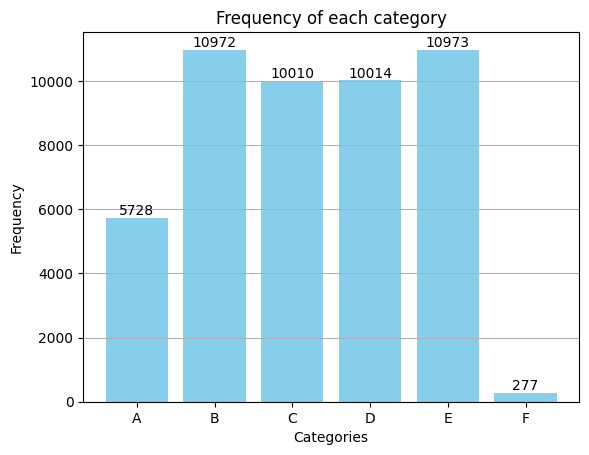

In [ ]:
# Count the frequency of each category
unique_categories, counts = np.unique(categories, return_counts=True)

# Create a bar plot
plt.bar(unique_categories, counts, color='skyblue')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Frequency of each category')
plt.grid(axis='y')

# Add counts on top of the bars
for i, count in enumerate(counts):
  plt.text(unique_categories[i], count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()


Classes **B**, **C**, **D**, **E** are equally balanced with 10000 samples each. Class **A** has half samples, instead class **F** is much underrepresented.

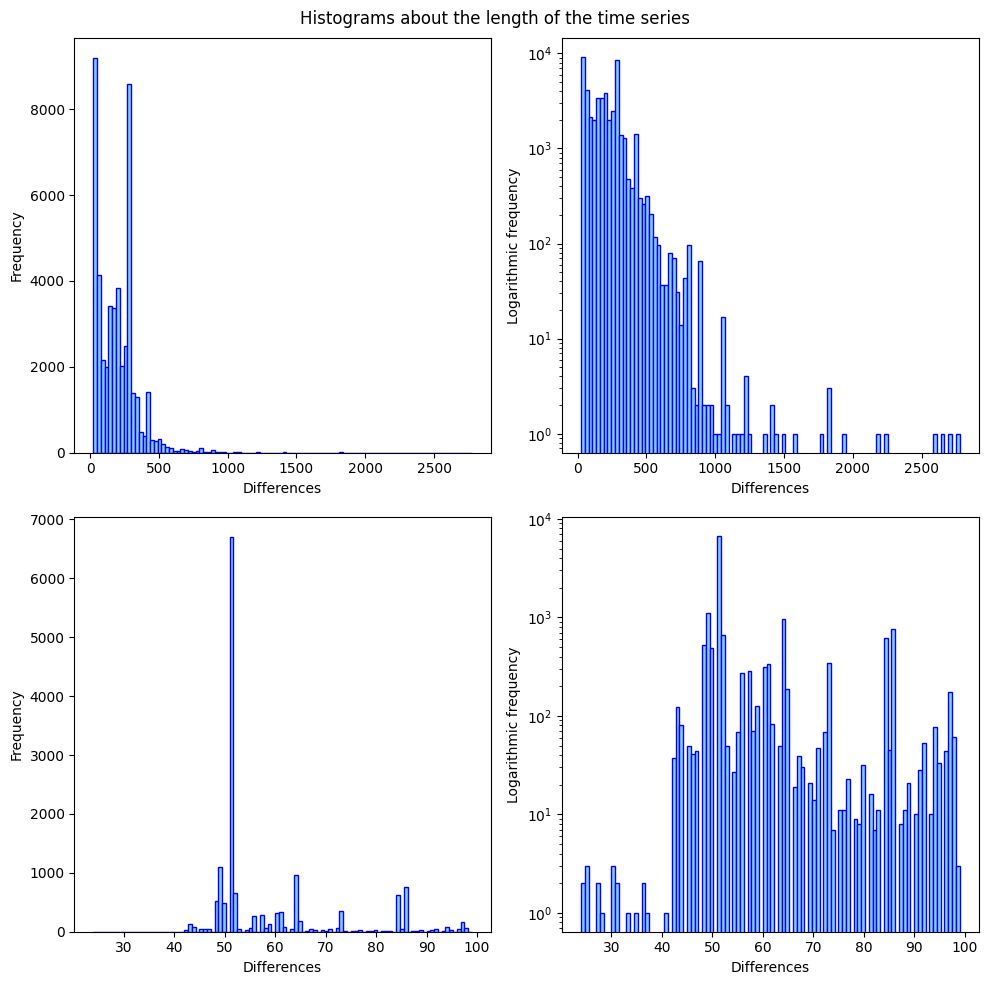

In [ ]:
# Calculating differences between ending point and starting point of the time
# series contained in the dataset
differences = valid_periods[:, 1] - valid_periods[:, 0]
# Cropping a part of the differences to focus on some interval
differences_cropped = differences[differences < 100]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Histograms about the length of the time series')
axes = axes.flatten()

# Creating a histogram plot
axes[0].hist(differences, bins=100, color='skyblue', edgecolor='blue')

# Adding labels
axes[0].set_xlabel('Differences')
axes[0].set_ylabel('Frequency')

# Creating a histogram plot
axes[1].hist(differences, bins=100, color='skyblue', edgecolor='blue', log=True)

# Adding labels
axes[1].set_xlabel('Differences')
axes[1].set_ylabel('Logarithmic frequency')

# Creating a histogram plot
axes[2].hist(differences_cropped, bins=100, color='skyblue', edgecolor='blue')

# Adding labels
axes[2].set_xlabel('Differences')
axes[2].set_ylabel('Frequency')

# Creating a histogram plot
axes[3].hist(differences_cropped, bins=100, color='skyblue', edgecolor='blue', log=True)

# Adding labels
axes[3].set_xlabel('Differences')
axes[3].set_ylabel('Logarithmic frequency')

# Showing the plot
plt.tight_layout()
plt.show()

There are a lot of time series with length between 0 and 1000. A small number of samples with very wide interavals are present in the dataset. Inspecting the dataset is possible to see that a small number of samples have a length smaller than 40. This is an important information that could be used to eliminate samples that are too small to be used to train the model.

### 1.5 Pre-processing

In [4]:
def create_dataset(original_data: np.ndarray,
                   intervals: np.ndarray,
                   window: int,
                   stride: int,
                   telescope: int) -> np.ndarray:
  '''
  Create a dataset from the original data based on specified window, stride, and telescope.

  Parameters:
    original_data (numpy.ndarray): Original data.
    intervals (numpy.ndarray): Intervals of each sample in the original data.
    window (int): Size of the window.
    stride (int): Stride for creating new samples.
    telescope (int): Size of the telescope.

  Returns:
    numpy.ndarray: New samples created from the original data.
      First element: Features (input data).
      Second element: Corresponding targets for the new samples.
  '''

  new_samples = []
  new_targets = []

  # Iterating through each sample in the original data
  for sample_idx, sample in enumerate(tqdm(original_data, desc="Creating Dataset")):
    # Extracting the relevant time series based on the provided intervals
    series = sample[int(intervals[sample_idx,0]):int(intervals[sample_idx,1])]
    length_sample = series.shape[0]

    # Calculating the number of samples that can be extracted from the current
    # sample
    if length_sample >= window + telescope:
      n_new_samples = ((length_sample - window - telescope) // stride)
    elif length_sample > telescope:
      n_new_samples = 1
    else:
      n_new_samples = 0

    if n_new_samples > 0:
      # Initializing arrays for features and targets
      features = np.zeros((n_new_samples, window))
      targets = np.zeros((n_new_samples, telescope))

      # Creating the new dataset for the considered sample
      for i in range(n_new_samples):
        start = length_sample - i * stride - window - telescope
        end = start + window

        if start >= 0:
          features[i, :] = series[start:end]
          targets[i, :] = series[end : end + telescope]
        else:
          # Padding for cases where the start index is negative
          features[i, :] = np.pad(series[0:end], ((window - end, 0)), 'constant', constant_values=0)
          targets[i, :] = series[end : end + telescope]

      # Appending the features and targets to the new_samples and new_targets lists
      for element in features:
        new_samples.append(element)
      for element in targets:
        new_targets.append(element)

  # Converting the lists to numpy arrays before returning
  return np.array(new_samples), np.array(new_targets)


In [ ]:
def create_dataset_with_category_encoding(original_data: np.ndarray,
                                          intervals: np.ndarray,
                                          categories: np.ndarray,
                                          window: int,
                                          stride: int,
                                          telescope: int) -> np.ndarray:
  '''
  Create a dataset from the original data based on specified window, stride, and telescope.
  It also return the one hot encoding of the category.

  Parameters:
    original_data (numpy.ndarray): Original data.
    intervals (numpy.ndarray): Intervals of each sample in the original data.
    categories (numpy.ndarray): Category of each sample in the original data.
    window (int): Size of the window.
    stride (int): Stride for creating new samples.
    telescope (int): Size of the telescope.

  Returns:
    numpy.ndarray: New samples created from the original data.
      First element: Features (input data).
      Second element: Corresponding targets for the new samples.
      Third element: Corresponding category for the new samples.
  '''

  new_samples = []
  new_targets = []
  new_categories = []

  # Perform one-hot encoding
  categories_series = pd.Series(categories)
  one_hot_encoded = pd.get_dummies(categories_series).values

  # Iterating through each sample in the original data
  for sample_idx, sample in enumerate(tqdm(original_data, desc="Creating Dataset")):
    # Extracting the relevant time series based on the provided intervals
    series = sample[int(intervals[sample_idx,0]):int(intervals[sample_idx,1])]
    length_sample = series.shape[0]

    # Calculating the number of samples that can be extracted from the current
    # sample
    if length_sample >= window + telescope:
      n_new_samples = ((length_sample - window - telescope) // stride)
    elif length_sample > telescope:
      n_new_samples = 1
    else:
      n_new_samples = 0

    if n_new_samples > 0:
      # Initializing arrays for features and targets
      features = np.zeros((n_new_samples, window))
      targets = np.zeros((n_new_samples, telescope))
      categories_ohe = np.zeros((n_new_samples, one_hot_encoded.shape[1]))
      # Creating the new dataset for the considered sample
      for i in range(n_new_samples):
        start = length_sample - i * stride - window - telescope
        end = start + window

        if start >= 0:
          features[i, :] = series[start:end]
          targets[i, :] = series[end : end + telescope]
          categories_ohe[i, :] = one_hot_encoded[sample_idx, :]
        else:
          # Padding for cases where the start index is negative
          features[i, :] = np.pad(series[0:end], ((window - end, 0)), 'constant', constant_values=0)
          targets[i, :] = series[end : end + telescope]
          categories_ohe[i, :] = one_hot_encoded[sample_idx, :]

      # Appending the features and targets to the new_samples and new_targets lists
      for element in features:
        new_samples.append(element)
      for element in targets:
        new_targets.append(element)
      for element in categories_ohe:
        new_categories.append(element)

  # Converting the lists to numpy arrays before returning
  return np.array(new_samples), np.array(new_targets), np.array(new_categories)

### 1.6. Experiment Tracking

Since one of the main problems in the previous challenge was tracking all our experiments, including hyperparameters and metrics, we decided to lavarage on an automatic tool, i.e. `comet-ml`, to do so. We aslo tried `TensorBoard` but Comet turned out to fit better our needs.

In the following section, some utility functions are created to handle this new feature.

In [ ]:
def create_experiment(experiment_name = None) -> comet_ml.Experiment:
    new_experiment = Experiment(
        auto_histogram_weight_logging=True,
        auto_histogram_gradient_logging=True,
        auto_histogram_activation_logging=True,
    )

    new_experiment.set_name(experiment_name)

    return new_experiment

def end_experiment(experiment : comet_ml.Experiment) -> None:
    experiment.end()

Whenever a new design session is started, the following steps should be done in sequence:
1. Generate a new experiment: `experiment = create_experiment('Experiment Name')`
2. Set the hyperparameters in dictionaries and log them to comet. Comet automatically logs important params about the training session. To log specific hyperparams, it is suggested to log them manually. It follows an example:
```python
training_hyperparameters = {
    'batch_size'        : 1024,
    'num_epochs'        : 200,
    'validation_split'  : 0.1,
    'ES_patience'       : 20,
    'R_LR_O_P_patience' : 10,
    'R_LR_O_P_factor'   : 0.1,
    'R_LR_O_P_min_lr'   : 1e-5
    ... eventually other params
}
experiment.log_parameters(training_hyperparameters)
```
```python
network_hyperparameters = {
    'hidden_layer1_units' : 256,
    'hidden_layer1_activ' : 'relu',
    'hidden_layer2_units' : 128,
    'hidden_layer2_activ' : 'relu',
    'conv1d_kernel_size'  : 3,
    'conv1d_stride'       : 1,
    ...... eventually other params
}
experiment.log_parameters(network_hyperparameters)
```
3. Execute the cell `experiment.display(tab='charts')` before starting training to display directly comet inside the notebook (otherwise visualize the training status directly on the comet web panel). **(optional)**
4. Run the training.
5. Whenever the experiment is done, **remember** to shutdown the experiment using `end_experiment(experiment)`.

There other possible logging features (e.g. logging the hash of the train/valid/test dataset) but here they're not used.

## 2. Models

### 2.1 Utility functions

In [20]:
def plot_training(history):
  '''
    Plots training and validation performance metrics, including loss and
    learning rate history, and highlights the epoch with the lowest validation loss.

    This function takes a history dictionary that contains training and
    validation metrics recorded during model training and visualizes the
    training and validation performance over epochs. It also highlights
    the epoch with the lowest validation loss.

    Parameters:
        history (dict): A dictionary containing training and validation metrics
        (e.g., loss, learning rate history) recorded during model training.

    Returns:
        None
  '''

  # Find the epoch with the highest validation accuracy
  best_epoch = np.argmin(history['val_loss'])

  # Plot training and validation performance metrics
  plt.figure(figsize=(20, 5))

  # Plot training and validation loss
  plt.plot(history['loss'], label='Training loss', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_loss'], label='Validation loss', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.legend(loc='upper right')
  plt.title('Mean Squared Error')
  plt.grid(alpha=0.3)

  plt.figure(figsize=(20, 5))

  # Plot learning rate history, highlighting the best epoch
  plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.legend(loc='upper right')
  plt.title('Learning rate history')
  plt.grid(alpha=0.3)

  plt.show()

In [21]:
def test_model(input : np.ndarray,
              y_test : np.ndarray,
              model_to_test : tf.keras.Model = None,
              model_name : str = None,
              telescope : int = 18,) -> None:
  '''
    Compute the MSE and MAE for the specified model on the specified test data.

    The function first checks whether a model or a model name is provided for
    evaluation. If neither is provided, it will print an error message and
    return without further execution.

    If a model is provided (model_to_test is not None), the function uses it for
    evaluation. If only a model name is provided, the function loads the saved
    model with that name using tf.keras.models.load_model.

    It then predicts labels for the test data using the model and calculates
    the MSE and MAE.

    Parameters:
      input (numpy.ndarray): Input data for testing.
      y_test (numpy.ndarray): Ground truth labels for the test data.
      model_to_test (tf.keras.Model, optional): The model to evaluate. If
        provided, this model will be used for evaluation.
      model_name (str, optional): The name of a saved Keras model to load for
      evaluation. If provided, this model will be loaded and used for
        evaluation.
      telescope (int, optional): Number of values to forecast,

    Returns:
      None
  '''

  if model_to_test is None and model_name is None:
    print("You have to specify either a model name or pass directly the model you want to evaluate.")
    return

  if model_to_test is not None:
    # Loading the model
    model = model_to_test
  else:
    model = tf.keras.models.load_model(model_name)

  # Predict the test set using the model
  predictions = model.predict(input, verbose=0)[:,:telescope]

  # Print the shape of the predictions
  print(f"Predictions shape: {predictions.shape}")

  # Calculate and print Mean Squared Error (MSE)
  mean_squared_error = tfk.metrics.mean_squared_error(y_test[:,:telescope].flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error: {mean_squared_error}")

  # Calculate and print Mean Absolute Error (MAE)
  mean_absolute_error = tfk.metrics.mean_absolute_error(y_test[:,:telescope].flatten(), predictions.flatten()).numpy()
  print(f"Mean Absolute Error: {mean_absolute_error}")

  if model_name:
    del model

In [22]:
def bootstrap_samples(samples : np.ndarray, labels : np.ndarray, num_samples : int, num_bootstraps : int = 1, replace : bool = True, seed : int = 42):
  '''
  Generates a bootstrap sample from a dataset.

  This function generates a bootstrap sample from a dataset by randomly
  sampling from the dataset with replacement.

  Parameters:
      samples (numpy.ndarray): The dataset from which to generate the bootstrap sample.
      labels (numpy.ndarray): The corresponding ground truth labels for the dataset.
      num_samples (int, optional): The number of samples to include in the bootstrap sample. Defaults to 1.
      num_bootstraps (int, optional): The number of bootstrap dataset to generate. Defaults to 1.
      replace (bool, optional): If true, sampling with replacement is performed. Defaults to True.
      seed (int, optional): Random seed for controlling the randomness of sampling.

  Returns:
      numpy.ndarray: The generated bootstrap sample.
  '''
  bootstrap_dataset = []
  for i in range(num_bootstraps):
    X_bootstrap, y_bootstrap = resample(samples, labels, replace=replace, n_samples=num_samples, stratify=np.argmax(labels, axis=1), random_state=seed+i)
    bootstrap_dataset.append((X_bootstrap, y_bootstrap))

  return bootstrap_dataset

In [23]:
def plot_comparison(predictions, target, num_plots=10):
  """
  Plots a visual comparison between predicted and target data.

  Parameters:
  - predictions (numpy.ndarray): Predicted data.
  - target (numpy.ndarray): Target (actual) data.
  - num_plots (int): Number of plots to display (default is 10).

  Returns:
  - None
  """

  # Calculating the number of rows for subplots
  num_rows = np.ceil(num_plots / 10).astype(int)

  # Creating subplots with specified layout and size
  fig, axes = plt.subplots(num_rows, 10, figsize=(30, 3 * num_rows))
  fig.suptitle('Target - Forecast Comparison')
  axes = axes.flatten()

  # Iterating through the subplots
  for i in range(num_rows * 10):
    ax = axes[i]

    # Plotting predicted data in orange
    ax.plot(predictions[i, :], color='orange', linewidth=2, marker='o', markersize=8, linestyle='--', label='Predicted')

    # Plotting target data in blue
    ax.plot(target[i, :], color='blue', linewidth=2, marker='o', markersize=8, linestyle='--', label='Target')

    # Setting axis labels
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    # Adding grid to the plot
    ax.grid(True)

  # Adjusting layout for better visualization
  plt.tight_layout()
  # Displaying the plot
  plt.show()

### Bidirectional LSTM model

In [13]:
def build_Bidirectional_LSTM_model(input_shape, output_shape):
  """
  Builds a Bidirectional LSTM model to do time series forecasting.

  Parameters:
  - input_shape (tuple): The shape of the input data.
  - output_shape (int): The number of units in the output layer.

  Returns:
  - tf.keras.Model: The constructed Bidirectional LSTM model.
  """

  # Defining the input layer with the specified shape
  input_layer = tfkl.Input(shape=input_shape, name='input_layer')

  # Adding a Bidirectional LSTM layers
  #x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm1'), name='bidirectional_lstm1')(input_layer)
  #x = tfkl.Dropout(rate=0.2, name='dropout1')(x)

  # Adding a Bidirectional LSTM layers
  x = tfkl.Bidirectional(tfkl.LSTM(64, name='last_lstm'), name='last_bidirectional_lstm')(input_layer)
  x = tfkl.Dropout(rate=0.2, name='last_dropout')(x)

  # Adding a dense output layer
  output_layer = tfkl.Dense(output_shape, name='output_layer')(x)

  # Constructing the model by connecting input and output layers
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Bidirectional_LSTM_model')

  # Compiling the model with Mean Squared Error loss and Adam optimizer
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

  return model

In [14]:
# Defining the hyperparameters to use to create the datasets
window = 130
stride = 18
telescope = 18
test_size = .1
validation_size = .1

# Filtering the series, keeping only the series longer than the sum of the
# window and the telescope
training_data_filtered = training_data[valid_periods[:,1]-valid_periods[:,0] > window+telescope]
intervals_filtered = valid_periods[valid_periods[:,1]-valid_periods[:,0] > window+telescope]
categories_filtered = categories[valid_periods[:,1]-valid_periods[:,0] > window+telescope]

# Splitting data into train plus validation sets and test set
X_train_val, X_test, intervals_class_train_val, intervals_class_test, categories_train_val, categories_test = train_test_split(training_data_filtered, intervals_filtered, categories_filtered, test_size=test_size, stratify=categories_filtered)

# Splitting train plus validation sets into train and validation sets
X_train, X_val, intervals_class_train, intervals_class_val, categories_train, categories_val = train_test_split(X_train_val, intervals_class_train_val, categories_train_val, test_size=validation_size, stratify=categories_train_val)

# Creating the dataset splitting it in windows
X_train, y_train = create_dataset(X_train, intervals_class_train, window, stride, telescope)
X_val, y_val = create_dataset(X_val, intervals_class_val, window, stride, telescope)
X_test, y_test = create_dataset(X_test, intervals_class_test, window, stride, telescope)

# Printing the shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Creating Dataset: 100%|██████████| 2950/2950 [00:00<00:00, 55159.92it/s]

X_train shape: (160646, 130), y_train shape: (160646, 18)
X_val shape: (17969, 130), y_val shape: (17969, 18)
X_test shape: (19926, 130), y_test shape: (19926, 18)


In [15]:
# Defining the hyperparameters to create and train the model
batch_size = 128
epochs = 150
input_shape = (X_train.shape[1], 1)
output_shape = y_train.shape[1]

# Creating the model
model = build_Bidirectional_LSTM_model(input_shape, output_shape)
model.summary()

# Training the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='loss', mode='min', patience=5, factor=0.9, min_lr=1e-5)
    ]
).history

# Saving the model
model.save(path_to_models+'BidirectionalLSTM_all_categories_'+str(window)+'_'+str(stride))

Model: "Bidirectional_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 130, 1)]          0         
                                                                 
 last_bidirectional_lstm (B  (None, 128)               33792     
 idirectional)                                                   
                                                                 
 last_dropout (Dropout)      (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 18)                2322      
                                                                 
Total params: 36114 (141.07 KB)
Trainable params: 36114 (141.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
1256/1256 [==============================] - 31s 18ms/step

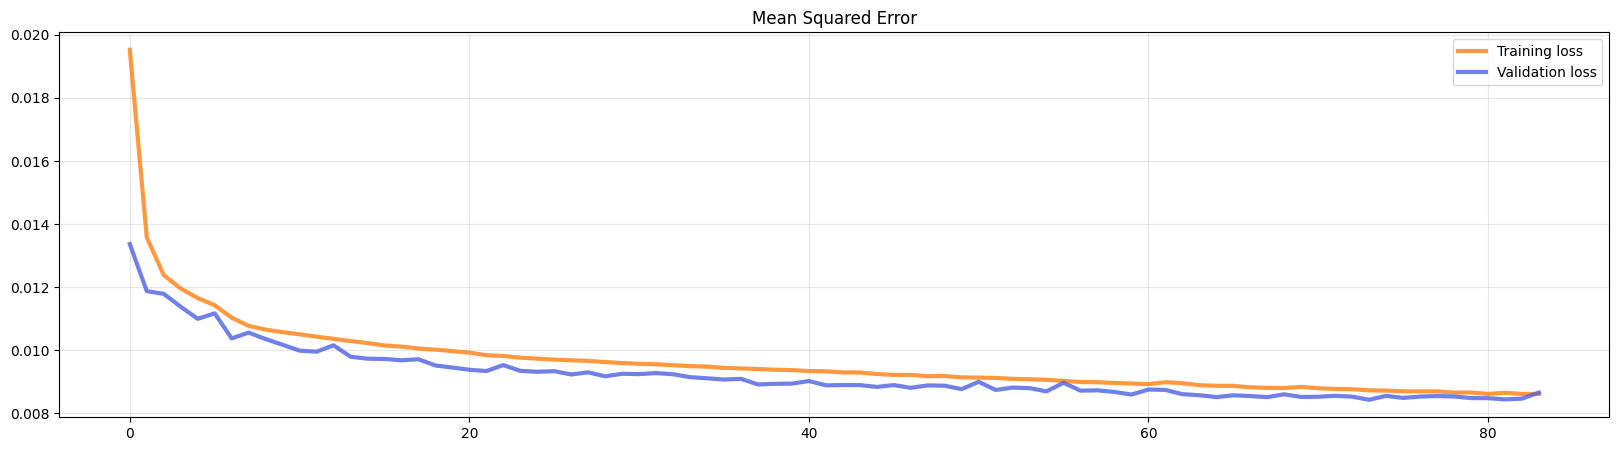

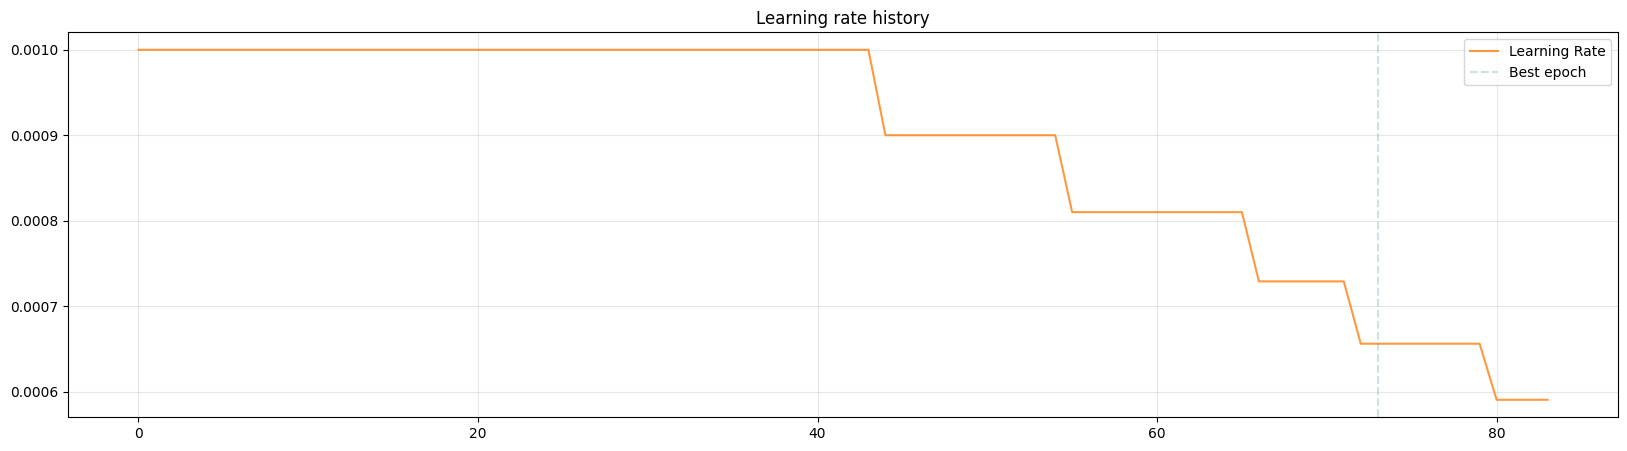

In [17]:
# Plotting the history of training
plot_training(history)

Predictions shape: (17969, 18)
Mean Squared Error: 0.00842976476997137
Mean Absolute Error: 0.05990047752857208
562/562 [==============================] - 5s 9ms/step


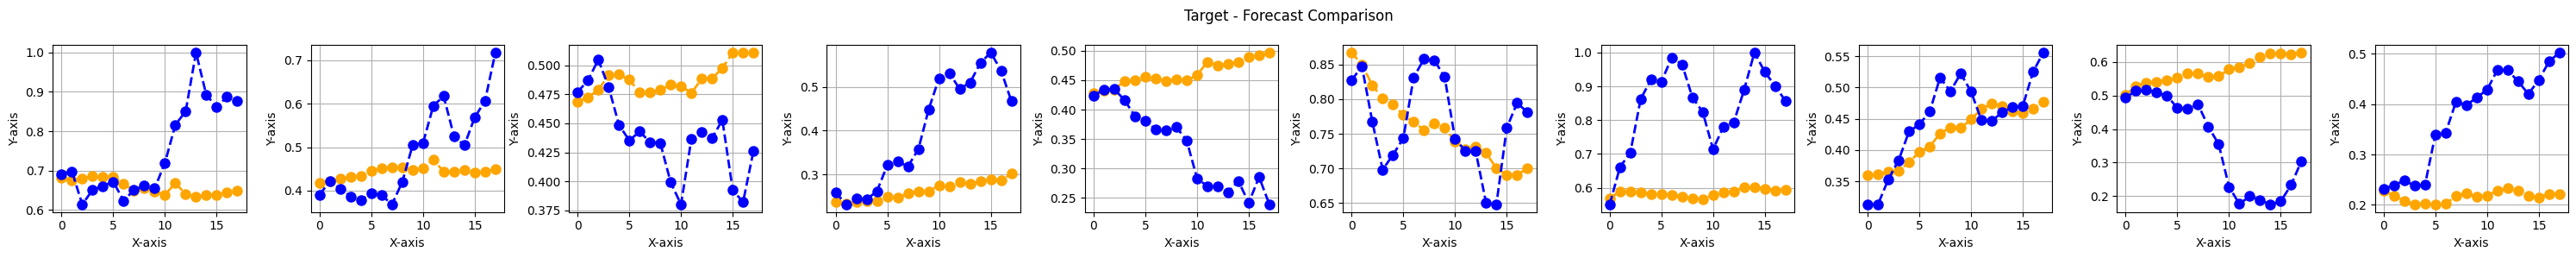

In [24]:
# Computing the error on the validation set
test_model(X_val, y_val, model_to_test=model)

# Plotting the comparison between the prediction on the validation set and the
# targets
plot_comparison(model.predict(X_val), y_val)

Predictions shape: (19926, 18)
Mean Squared Error: 0.008638069033622742
Mean Absolute Error: 0.060371335595846176
623/623 [==============================] - 3s 5ms/step


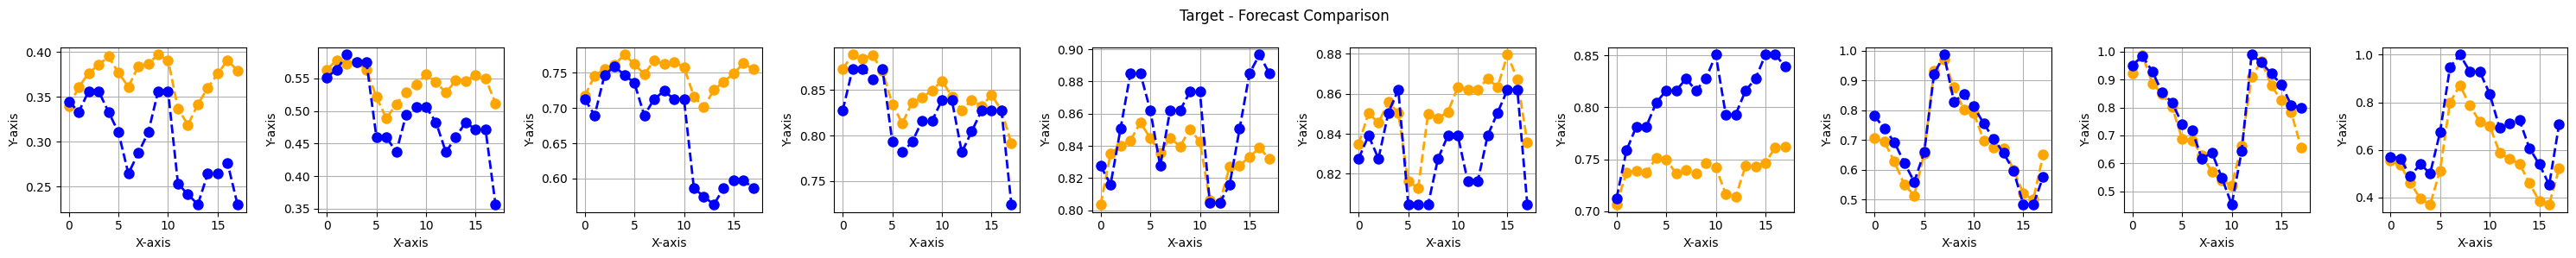

In [25]:
print('Telescope = 18:')
# Computing the error on the test set
test_model(X_test, y_test, model_to_test=model, telescope=18)

print('\nTelescope = 9:')
# Computing the error on the test set
test_model(X_test, y_test, model_to_test=model, telescope=9)

# Plotting the comparison between the prediction on the test set and the targets
plot_comparison(model.predict(X_test), y_test)

### Convolutional LSTM model

In [51]:
def build_CONV_LSTM_model(input_shape, output_shape):
  """
  Builds a Convolutional LSTM model to do time series forecasting.

  Parameters:
  - input_shape (tuple): The shape of the input data.
  - output_shape (int): The number of units in the output layer.

  Returns:
  - tf.keras.Model: The constructed Convolutional LSTM model.
  """

  # Defining the input layer with the specified shape
  input_layer = tfkl.Input(shape=input_shape, name='input_layer')

  # Adding a Bidirectional LSTM layers
  x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm1'), name='bidirectional_lstm1')(input_layer)
  x = tfkl.Dropout(rate=0.2, name='dropout1')(x)

  # Adding a 1D Convolution layer
  x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv1')(x)
  # Adding a 1D Convolution layer
  x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv2')(x)

  # Adding a final Convolution layer to have a one-dimensional output
  output_layer = tfkl.Conv1D(1, 3, padding='same', name='output_layer')(x)

  # Calculating the size to crop from the output to match the output shape
  crop_size = output_layer.shape[1] - output_shape

  # Cropping the output to the desired length
  output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

  # Constructing the model by connecting input and output layers
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

  # Compiling the model with Mean Squared Error loss and Adam optimizer
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

  return model

In [52]:
# Defining the hyperparameters to use to create the datasets
window = 130
stride = 18
telescope = 18
test_size = .1
validation_size = .1

# Filtering the series, keeping only the series longer than the sum of the
# window and the telescope
training_data_filtered = training_data[valid_periods[:,1]-valid_periods[:,0] > window+telescope]
intervals_filtered = valid_periods[valid_periods[:,1]-valid_periods[:,0] > window+telescope]
categories_filtered = categories[valid_periods[:,1]-valid_periods[:,0] > window+telescope]

# Splitting data into train plus validation sets and test set
X_train_val, X_test, intervals_class_train_val, intervals_class_test, categories_train_val, categories_test = train_test_split(training_data_filtered, intervals_filtered, categories_filtered, test_size=test_size, stratify=categories_filtered)

# Splitting train plus validation sets into train and validation sets
X_train, X_val, intervals_class_train, intervals_class_val, categories_train, categories_val = train_test_split(X_train_val, intervals_class_train_val, categories_train_val, test_size=validation_size, stratify=categories_train_val)

# Creating the dataset splitting it in windows
X_train, y_train = create_dataset(X_train, intervals_class_train, window, stride, telescope)
X_val, y_val = create_dataset(X_val, intervals_class_val, window, stride, telescope)
X_test, y_test = create_dataset(X_test, intervals_class_test, window, stride, telescope)

# Printing the shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Creating Dataset: 100%|██████████| 2950/2950 [00:00<00:00, 47617.24it/s]

X_train shape: (160797, 130), y_train shape: (160797, 18)
X_val shape: (17863, 130), y_val shape: (17863, 18)
X_test shape: (19881, 130), y_test shape: (19881, 18)


In [ ]:
# Defining the hyperparameters to create and train the model
batch_size = 128
epochs = 150
input_shape = (X_train.shape[1], 1)
output_shape = y_train.shape[1]

# Creating the model
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

# Training the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='loss', mode='min', patience=5, factor=0.9, min_lr=1e-5)
    ]
).history

# Saving the model
model.save(path_to_models+'ConvLSTM_all_categories_'+str(window)+'_'+str(stride))

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 130, 1)]          0         
                                                                 
 bidirectional_lstm1 (Bidir  (None, 130, 256)          133120    
 ectional)                                                       
                                                                 
 dropout1 (Dropout)          (None, 130, 256)          0         
                                                                 
 conv1 (Conv1D)              (None, 130, 128)          98432     
                                                                 
 conv2 (Conv1D)              (None, 130, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 130, 1)            385       
                                                   

In [ ]:
# Plotting the history of training
plot_training(history)

In [ ]:
# Computing the error on the validation set
test_model(X_val, y_val, model_to_test=model)

# Plotting the comparison between the prediction on the validation set and the
# targets
plot_comparison(model.predict(X_val), y_val)

In [ ]:
print('Telescope = 18:')
# Computing the error on the test set
test_model(X_test, y_test, model_to_test=model, telescope=18)

print('\nTelescope = 9:')
# Computing the error on the test set
test_model(X_test, y_test, model_to_test=model, telescope=9)

# Plotting the comparison between the prediction on the test set and the targets
plot_comparison(model.predict(X_test), y_test)

### Fully convolutional model

In [33]:
def build_fullyConvolutional_model(input_shape, output_shape):
  """
  Builds a fully Convolutional model to do time series forecasting.

  Parameters:
  - input_shape (tuple): The shape of the input data.
  - output_shape (int): The number of units in the output layer.

  Returns:
  - tf.keras.Model: The constructed fully Convolutional model.
  """

  # Defining the input layer with the specified shape
  input_layer = tfkl.Input(shape=input_shape, name='input_layer')

  # Adding some convolutional layers
  x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv1')(input_layer)
  x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv2')(x)
  x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv3')(x)
  x = tfkl.Conv1D(32, 3, padding='same', activation='relu', name='conv4')(x)
  x = tfkl.Conv1D(32, 3, padding='same', activation='relu', name='conv5')(x)
  x = tfkl.Conv1D(32, 3, padding='same', activation='relu', name='conv6')(x)

  # Adding the last convolutional layer with a number of filters that is the
  # number of values to predict in the output
  x = tfkl.Conv1D(output_shape, 3, padding='same', activation='relu', name='last_conv')(x)
  x = tfkl.Dropout(rate=0.2)(x)

  # Adding a global average pooling layer used to obtain the correct output shape
  output_layer = tfkl.GlobalAveragePooling1D(name='avg')(x)

  # Constructing the model by connecting input and output layers
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

  # Compiling the model with Mean Squared Error loss and Adam optimizer
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

  return model

In [34]:
# Defining the hyperparameters to use to create the datasets
window = 130
stride = 18
telescope = 18
test_size = .1
validation_size = .1

# Filtering the series, keeping only the series longer than the sum of the
# window and the telescope
training_data_filtered = training_data[valid_periods[:,1]-valid_periods[:,0] > window+telescope]
intervals_filtered = valid_periods[valid_periods[:,1]-valid_periods[:,0] > window+telescope]
categories_filtered = categories[valid_periods[:,1]-valid_periods[:,0] > window+telescope]

# Splitting data into train plus validation sets and test set
X_train_val, X_test, intervals_class_train_val, intervals_class_test, categories_train_val, categories_test = train_test_split(training_data_filtered, intervals_filtered, categories_filtered, test_size=test_size, stratify=categories_filtered)

# Splitting train plus validation sets into train and validation sets
X_train, X_val, intervals_class_train, intervals_class_val, categories_train, categories_val = train_test_split(X_train_val, intervals_class_train_val, categories_train_val, test_size=validation_size, stratify=categories_train_val)

# Creating the dataset splitting it in windows
X_train, y_train = create_dataset(X_train, intervals_class_train, window, stride, telescope)
X_val, y_val = create_dataset(X_val, intervals_class_val, window, stride, telescope)
X_test, y_test = create_dataset(X_test, intervals_class_test, window, stride, telescope)

# Printing the shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Creating Dataset: 100%|██████████| 2950/2950 [00:00<00:00, 57516.31it/s]

X_train shape: (160945, 130), y_train shape: (160945, 18)
X_val shape: (17803, 130), y_val shape: (17803, 18)
X_test shape: (19793, 130), y_test shape: (19793, 18)


In [35]:
# Defining the hyperparameters to create and train the model
batch_size = 128
epochs = 150
input_shape = (X_train.shape[1], 1)
output_shape = y_train.shape[1]

# Creating the model
model = build_fullyConvolutional_model(input_shape, output_shape)
model.summary()

# Training the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='loss', mode='min', patience=5, factor=0.9, min_lr=1e-5)
    ]
).history

# Saving the model
model.save(path_to_models+'fullyConv_all_categories_'+str(window)+'_'+str(stride))

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 130, 1)]          0         
                                                                 
 conv1 (Conv1D)              (None, 130, 64)           256       
                                                                 
 conv2 (Conv1D)              (None, 130, 64)           12352     
                                                                 
 conv3 (Conv1D)              (None, 130, 64)           12352     
                                                                 
 conv4 (Conv1D)              (None, 130, 32)           6176      
                                                                 
 conv5 (Conv1D)              (None, 130, 32)           3104      
                                                                 
 conv6 (Conv1D)              (None, 130, 32)       

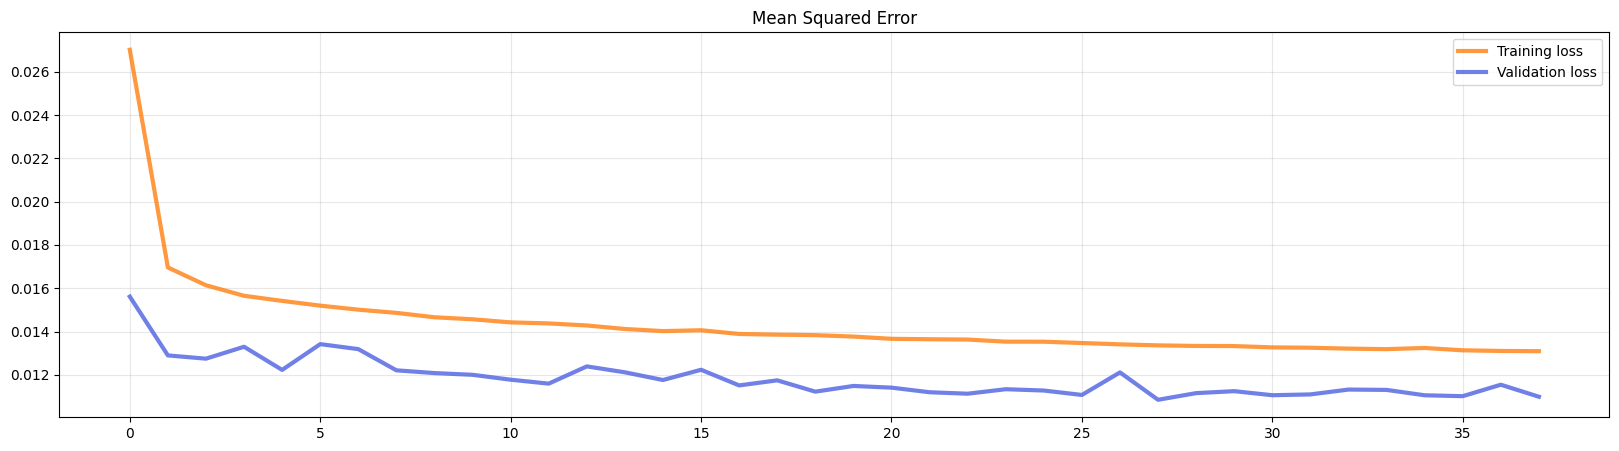

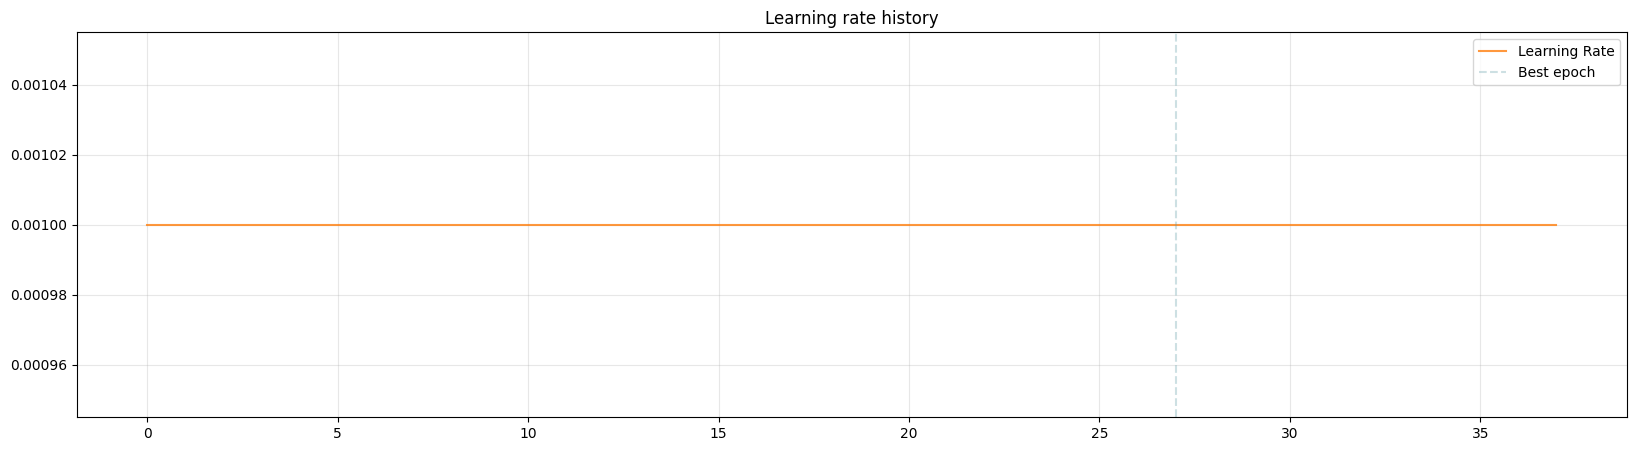

In [36]:
# Plotting the history of training
plot_training(history)

Predictions shape: (17803, 18)
Mean Squared Error: 0.010846685618162155
Mean Absolute Error: 0.07312285900115967
557/557 [==============================] - 1s 2ms/step


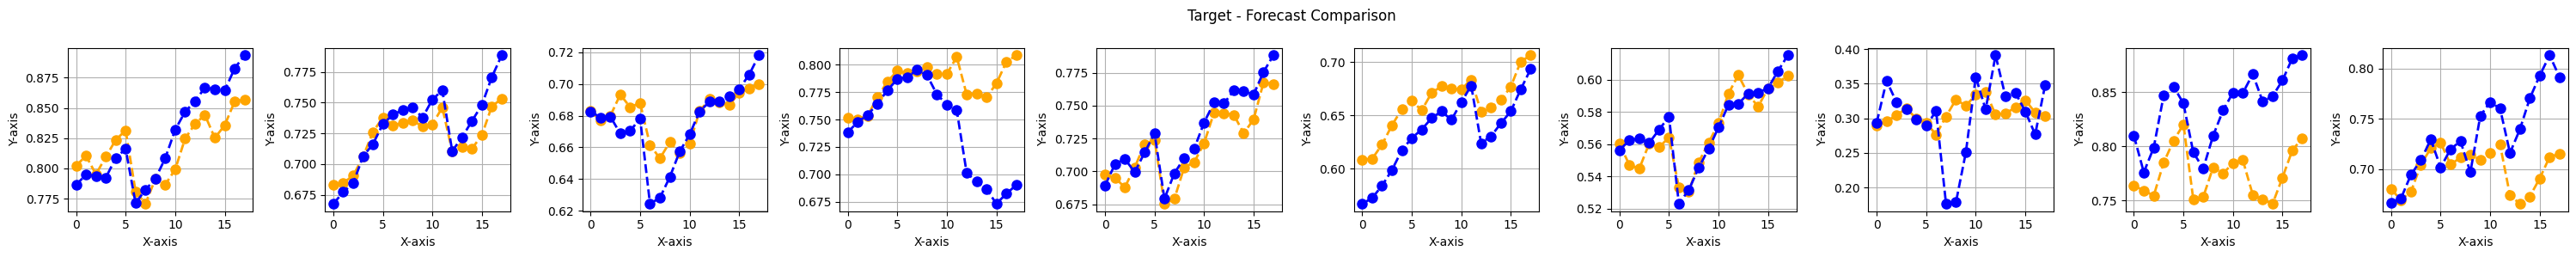

In [37]:
# Computing the error on the validation set
test_model(X_val, y_val, model_to_test=model)

# Plotting the comparison between the prediction on the validation set and the
# targets
plot_comparison(model.predict(X_val), y_val)

Predictions shape: (19793, 18)
Mean Squared Error: 0.011056778021156788
Mean Absolute Error: 0.07355114072561264
619/619 [==============================] - 1s 2ms/step


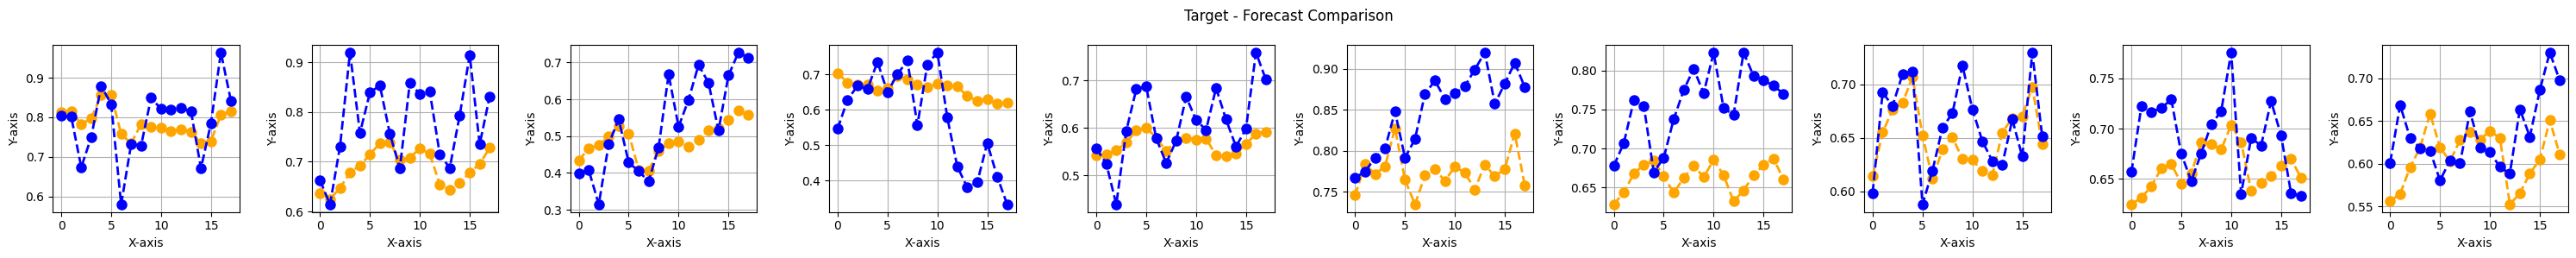

In [38]:
print('Telescope = 18:')
# Computing the error on the test set
test_model(X_test, y_test, model_to_test=model, telescope=18)

print('\nTelescope = 9:')
# Computing the error on the test set
test_model(X_test, y_test, model_to_test=model, telescope=9)

# Plotting the comparison between the prediction on the test set and the targets
plot_comparison(model.predict(X_test), y_test)

### De-trending and de-seasoning

#### De-trending

In [47]:
def detrend_with_mask(x):
  """
  Detrends the input array, preserving zero values.

  Parameters:
  - x (numpy.ndarray): Input array to be detrended.

  Returns:
  - numpy.ndarray: Detrended array with zero values preserved.
  """

  # Creating a mask for non-zero values
  mask = x != 0

  # If all values are zero, return the original array
  if np.all(~mask):
      return x

  # Detrending only non-zero values
  detrended_values = detrend(x[mask])

  # Replacing the detrended values in the original array
  x[mask] = detrended_values

  return x

#### De-seasoning

In [48]:
def autocorrelation(ts, lag):
  """
  Computes autocorrelation of a time series at a specified lag.

  Parameters:
  - ts (array-like): Time series data.
  - lag (int): Lag at which to compute autocorrelation.

  Returns:
  - autocorr (float): Autocorrelation at the specified lag.
  """

  n = len(ts)
  mean_ts = np.mean(ts)
  numerator = np.sum((ts[:n-lag] - mean_ts) * (ts[lag:] - mean_ts))
  denominator = np.sum((ts - mean_ts) ** 2)

  autocorr = numerator / denominator if denominator != 0 else 0
  return autocorr

def find_local_max(acf_values):
  local_maxs = []
  for i in range(1, len(acf_values)-1):
    if acf_values[i]>acf_values[i-1] and acf_values[i]>acf_values[i+1]:
      local_maxs.append(i)

  return np.array(local_maxs)

def find_seasonality(ts, max_lag=40, significance_level=0.05, confidence=0.8):
    """
    Finds seasonality in a time series using autocorrelation.

    Parameters:
    - ts (array-like): Time series data.
    - max_lag (int): Maximum lag to consider in ACF.
    - significance_level (float): Significance level for detecting peaks in ACF.

    Returns:
    - seasonality_period (int): Detected seasonality period, or None if no significant seasonality is found.
    """

    max_eval_steps = 20

    acf_values = [autocorrelation(ts, lag) for lag in range(max_lag + 1)]

    # Plot ACF to visualize autocorrelation
    #plt.figure(figsize=(10, 4))
    #plt.stem(np.arange(0, max_lag + 1), acf_values, markerfmt='ro', basefmt=" ", use_line_collection=True)
    #plt.title('Autocorrelation Function (ACF)')
    #plt.xlabel('Lag')
    #plt.ylabel('Autocorrelation')
    #plt.show()

    local_max = find_local_max(acf_values)
    if len(local_max) <= 0:
      seasonality_period = -1
    else:
      best_local_max = np.argmax(np.array(acf_values)[local_max])
      seasonality_period = local_max[best_local_max]
      if 2*seasonality_period > len(ts) or 2*seasonality_period > max_lag or seasonality_period<=1:
        seasonality_period = -1
      else:
        behaviour_season_1 = np.zeros(seasonality_period-1)
        for i in range(1, seasonality_period):
          if acf_values[i]>acf_values[i-1]:
            behaviour_season_1[i-1] = 1
          else:
            behaviour_season_1[i-1] = -1
        behaviour_season_2 = np.zeros(seasonality_period-1)
        for i in range(seasonality_period+1, 2*seasonality_period):
          if acf_values[i]>acf_values[i-1]:
            behaviour_season_2[i-1-seasonality_period] = 1
          else:
            behaviour_season_2[i-1-seasonality_period] = -1

        if np.sum(behaviour_season_1==behaviour_season_2)/len(behaviour_season_1) < confidence:
          seasonality_period = -1

    #if seasonality_period == -1:
      #print('The series is not seasonal')

    return seasonality_period

def remove_seasonality_return_telescope(time_series, telescope):
  '''
  time_series shape has to be (length,)
  '''
  detected_seasonality = find_seasonality(time_series, max_lag=50, confidence=0.9)
  if detected_seasonality != -1:
    detrended_deseasonalized_series = pd.DataFrame(time_series).diff(detected_seasonality).to_numpy()

    seasonality = time_series[:,None] - detrended_deseasonalized_series
    seasonality = seasonality[detected_seasonality:,0]
    for i in range(detected_seasonality):
      detrended_deseasonalized_series[i,0] = 0.

    remainder = seasonality.shape[0] % detected_seasonality
    if remainder != 0:
      seasonality = seasonality[remainder:]

    reversed_seasonality = np.flip(seasonality)
    sections = np.split(reversed_seasonality, np.arange(detected_seasonality, len(reversed_seasonality), detected_seasonality))
    reversed_sections = [np.flip(section) for section in sections]

    average_seasonality = np.mean(np.array(reversed_sections), axis=0)

    num_repetitions = -(-telescope // detected_seasonality) + 1
    season_telescope = np.tile(average_seasonality, num_repetitions)[:telescope]

    num_repetitions = -(-time_series.shape[0] // detected_seasonality) + 1
    average_seasonality = np.tile(average_seasonality, num_repetitions)[:time_series.shape[0]]

    detrended_deseasonalized_series = detrended_deseasonalized_series.T
    average_seasonality = average_seasonality[None, :]
    season_telescope = season_telescope[None, :]

  else:
    detrended_deseasonalized_series = time_series[None, :]
    average_seasonality = np.zeros((1,time_series.shape[0]))
    season_telescope = np.zeros((1,telescope))

  return detrended_deseasonalized_series, average_seasonality, season_telescope

def remove_seasonality_dataset(X, y, telescope):
  new_X = np.zeros(X.shape)
  seasonality = np.zeros(X.shape)
  seasonality_y = np.zeros(y.shape)
  new_y = np.zeros(y.shape)

  for i in tqdm(range(X.shape[0])):
    series = X[i]
    deseasonalized_series, seasonality_series, y_seasonality_series = remove_seasonality_return_telescope(series, telescope)
    new_X[i, :] = deseasonalized_series
    seasonality[i, :] = seasonality_series
    new_y[i, :] = y[i, :] - y_seasonality_series
    seasonality_y[i, :] = y_seasonality_series

  return new_X, new_y, seasonality, seasonality_y

def test():
  i = 2456

  length = valid_periods[i, 1] - valid_periods[i, 0]
  series = training_data[i, valid_periods[i, 0]:valid_periods[i, 1]].flatten()
  plt.plot(series)
  plt.show()

  detrended_series = detrend(training_data[i,valid_periods[i, 0]:valid_periods[i, 1]])
  plt.plot(detrended_series)
  plt.show()

  detected_seasonality = find_seasonality(detrended_series, max_lag=50, confidence=0.9)
  if detected_seasonality != -1:
    detrended_deseasonalized_series, seasonality, season_telescope = remove_seasonality_return_telescope(series, 18)
    detrended_deseasonalized_series = pd.DataFrame(detrended_series).diff(detected_seasonality)
    plt.plot(detrended_deseasonalized_series)
    plt.show()

  if detected_seasonality != -1:
    print(f"Detected Seasonality Period: {detected_seasonality}")

#### Training and testing a model

In [ ]:
# Defining the hyperparameters to use to create the datasets
window = 130
stride = 18
telescope = 18
test_size = .1
validation_size = .1

# Filtering the series, keeping only the series longer than the sum of the
# window and the telescope
training_data_filtered = training_data[valid_periods[:,1]-valid_periods[:,0] > window+telescope]
intervals_filtered = valid_periods[valid_periods[:,1]-valid_periods[:,0] > window+telescope]
categories_filtered = categories[valid_periods[:,1]-valid_periods[:,0] > window+telescope]

# Splitting data into train plus validation sets and test set
X_train_val, X_test, intervals_class_train_val, intervals_class_test, categories_train_val, categories_test = train_test_split(training_data_filtered, intervals_filtered, categories_filtered, test_size=test_size, stratify=categories_filtered)

# Splitting train plus validation sets into train and validation sets
X_train, X_val, intervals_class_train, intervals_class_val, categories_train, categories_val = train_test_split(X_train_val, intervals_class_train_val, categories_train_val, test_size=validation_size, stratify=categories_train_val)

# Creating the dataset splitting it in windows
X_train, y_train = create_dataset(X_train, intervals_class_train, window, stride, telescope)
X_val, y_val = create_dataset(X_val, intervals_class_val, window, stride, telescope)
X_test, y_test = create_dataset(X_test, intervals_class_test, window, stride, telescope)

# Printing the shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# De-trending the datasets
X_train_detrended = np.apply_along_axis(detrend_with_mask, axis=1, arr=X_train.copy())
X_train_trends = X_train - X_train_detrended
difference = X_train_trends[:, -1] - X_train_trends[:, -2]
y_train_trends = difference[:, np.newaxis] * range(1, telescope + 1) + X_train_trends[:, -1][:,None] @ np.array([1 for _ in range(telescope)])[None, :]
y_train_detrended = y_train - y_train_trends
X_val_detrended = np.apply_along_axis(detrend_with_mask, axis=1, arr=X_val.copy())
X_val_trends = X_val - X_val_detrended
difference = X_val_trends[:, -1] - X_val_trends[:, -2]
y_val_trends = difference[:, np.newaxis] * range(1, telescope + 1) + X_val_trends[:, -1][:,None] @ np.array([1 for _ in range(telescope)])[None, :]
y_val_detrended = y_val - y_val_trends
X_test_detrended = np.apply_along_axis(detrend_with_mask, axis=1, arr=X_test.copy())
X_test_trends = X_test - X_test_detrended
difference = X_test_trends[:, -1] - X_test_trends[:, -2]
y_test_trends = difference[:, np.newaxis] * range(1, telescope + 1) + X_test_trends[:, -1][:,None] @ np.array([1 for _ in range(telescope)])[None, :]
y_test_detrended = y_test - y_test_trends

# De-seasoning the datasets
X_train_detrended_deseasoned, y_train_detrended_deseasoned, X_train_seasonality, y_train_seasonality = remove_seasonality_dataset(X_train_detrended, y_train_detrended, telescope)
X_val_detrended_deseasoned, y_val_detrended_deseasoned, X_val_seasonality, y_val_seasonality = remove_seasonality_dataset(X_val_detrended, y_val_detrended, telescope)
X_test_detrended_deseasoned, y_test_detrended_deseasoned, X_test_seasonality, y_test_seasonality = remove_seasonality_dataset(X_test_detrended, y_test_detrended, telescope)

# Printing the shapes of the datasets
print(f"X_train shape: {X_train_detrended_deseasoned.shape}, y_train shape: {y_train_detrended_deseasoned.shape}")
print(f"X_val shape: {X_val_detrended_deseasoned.shape}, y_val shape: {y_val_detrended_deseasoned.shape}")
print(f"X_test shape: {X_test_detrended_deseasoned.shape}, y_test shape: {y_test_detrended_deseasoned.shape}")

In [ ]:
# Defining the hyperparameters to create and train the model
batch_size = 128
epochs = 150
input_shape = (X_train_detrended_deseasoned.shape[1], 1)
output_shape = y_train_detrended_deseasoned.shape[1]

# Creating the model
model = build_Bidirectional_LSTM_model(input_shape, output_shape)
model.summary()

# Training the model
history = model.fit(
    x = X_train_detrended_deseasoned,
    y = y_train_detrended_deseasoned,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val_detrended_deseasoned, y_val_detrended_deseasoned),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='loss', mode='min', patience=5, factor=0.9, min_lr=1e-5)
    ]
).history

# Saving the model
model.save(path_to_models+'detrended_deseasoned_BiLSTM_all_categories_'+str(window)+'_'+str(stride))

In [ ]:
# Plotting the history of training
plot_training(history)

In [ ]:
# Computing the error on the validation set
test_model(X_val_detrended_deseasoned, y_val_detrended_deseasoned, model_to_test=model)

# Plotting the comparison between the prediction on the validation set and the
# targets
plot_comparison(model.predict(X_val_detrended_deseasoned), y_val_detrended_deseasoned)

In [ ]:
print('Telescope = 18:')
# Computing the error on the test set
test_model(X_test_detrended_deseasoned, y_test_detrended_deseasoned, model_to_test=model, telescope=18)

print('\nTelescope = 9:')
# Computing the error on the test set
test_model(X_test_detrended_deseasoned, y_test_detrended_deseasoned, model_to_test=model, telescope=9)

# Plotting the comparison between the prediction on the test set and the targets
plot_comparison(model.predict(X_test_detrended_deseasoned), y_test_detrended_deseasoned)

#### Predicting with the trend and the season

In [ ]:
# Predicting the actual value of the series
predictions = y_val_trends + y_val_seasonality + model.predict(X_val_detrended_deseasoned)

# Computing the error on the validation set
print(f'Error with a prediction horizon of 18: {mean_squared_error(y_val, predictions)}')
print(f'Error with a prediction horizon of 9: {mean_squared_error(y_val[:,:9], predictions[:,:9])}')

# Plotting the comparison between the prediction on the validation set and the
# targets
plot_comparison(predictions, y_val)

In [ ]:
# Predicting the actual value of the series
predictions = y_test_trends + y_test_seasonality + model.predict(X_test_detrended_deseasoned)

# Computing the error on the test set
print(f'Error with a prediction horizon of 18: {mean_squared_error(y_test, predictions)}')
print(f'Error with a prediction horizon of 9: {mean_squared_error(y_test[:,:9], predictions[:,:9])}')

# Plotting the comparison between the prediction on the test set and the targets
plot_comparison(predictions, y_test)

### 2.2 Custom baseline

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Input, concatenate, Dense, Embedding

# Define LSTM for time series data
lstm_input = Input(shape=(sequence_length, num_features))
lstm_output = LSTM(units=64)(lstm_input)

# Define categorical input and embedding
cat_input = Input(shape=(1,))
cat_embedded = Embedding(num_categories, embedding_dim)(cat_input)
cat_flat = Flatten()(cat_embedded)

# Combine LSTM output with categorical input
combined = concatenate([lstm_output, cat_flat])

# Additional layers and output for forecasting
output = Dense(units=1, activation='linear')(combined)

model = Model(inputs=[lstm_input, cat_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

In [ ]:
model_name = 'LSTM2'
experiment = create_experiment(model_name)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/gdrive/MyDrive/[2023-2024] AN2DL/Homework 2' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/albertosandri/anndl-ts-forecasting/56d4eb0dba234fd386442c5efef8efd4



In [ ]:
training_hyperparameters = {
  'batch_size'        : 512,
  'num_epochs'        : 100,
  'validation_split'  : 0.2,
  'test_split'        : 0.2,
  'ES_patience'       : 15,
  'R_LR_O_P_patience' : 5,
  'R_LR_O_P_factor'   : 0.75,
  'R_LR_O_P_min_lr'   : 1e-6,
  'window'            : 200,
  'stride'            : 50,
  'telescope'         : 18,
}
experiment.log_parameters(training_hyperparameters)

In [ ]:
network_hyperparameters = {
  'hidden_layer1'       : 'Bi-LSTM',
  'hidden_layer1_units' : 128,
  #'hidden_layer1_activ' : 'relu',
  'hidden_layer1'       : 'LSTM',
  'hidden_layer2_units' : 64,
  'droput'              : 0.5,
  'cropping'            : True,
  'dense_layer_units'   : 18,
  #'hidden_layer2_activ' : 'relu',
  #'conv1d_kernel_size'  : 3,
  #'conv1d_stride'       : 1,
}
experiment.log_parameters(network_hyperparameters)

In [ ]:
class_idxs = categories == 'A'
print(f"Min lenght of a series: {np.min(valid_periods[class_idxs,1]-valid_periods[class_idxs,0])}")
print(f"Max lenght of a series: {np.max(valid_periods[class_idxs,1]-valid_periods[class_idxs,0])}")

In [ ]:
# Create the dataset
X, y = create_dataset(training_data, valid_periods, training_hyperparameters['window'], training_hyperparameters['stride'], training_hyperparameters['telescope'])

X.shape, y.shape

Creating Dataset: 100%|██████████| 47974/47974 [00:01<00:00, 32892.50it/s]


((100981, 200), (100981, 18))

In [ ]:
# Create the dataset
train_samples = training_data[categories == 'A']
valid_periods_train = valid_periods[categories == 'A']
X, y = create_dataset(train_samples, valid_periods_train, training_hyperparameters['window'], training_hyperparameters['stride'], training_hyperparameters['telescope'])

X.shape, y.shape

In [ ]:
# Defining the number of samples in the test set and in the validation set
validation_size = training_hyperparameters['validation_split']
test_size = training_hyperparameters['test_split']

X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(y.shape[0], y.shape[1], 1)

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=validation_size)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (64627, 200, 1), y_train shape: (64627, 18, 1)
X_val shape: (16157, 200, 1), y_val shape: (16157, 18, 1)
X_test shape: (20197, 200, 1), y_test shape: (20197, 18, 1)


In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

input_shape, output_shape

((200, 1), (18, 1))

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    print(output_layer.shape[1])
    print(output_shape[0])
    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
def build_LSTM_classifier(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128, return_sequences=True)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)
    crop_size = dropout.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    # Return the model
    return model

In [ ]:
def build_bidirectional_LSTM(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Bidirectional LSTM layers
    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    lstm = tfkl.LSTM(64, return_sequences=True)(lstm)
    dropout = tfkl.Dropout(0.5)(lstm)
    crop_size = dropout.shape[1] - output_shape[0]

    # Crop the output to the desired length
    cropping = tfkl.Cropping1D((0, crop_size), name='cropping')(dropout)

    # Dense layer for output
    output_layer = tfkl.Dense(output_shape[1])(cropping)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 200, 256)          133120    
 onal)                                                           
                                                                 
 lstm_9 (LSTM)               (None, 200, 64)           82176     
                                                                 
 dropout_4 (Dropout)         (None, 200, 64)           0         
                                                                 
 cropping (Cropping1D)       (None, 18, 64)            0         
                                                                 
 dense_4 (Dense)             (None, 18, 1)             65        
                                                             

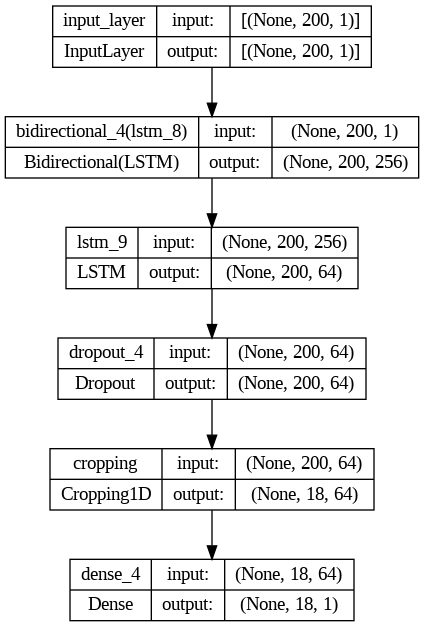

In [ ]:
model = build_bidirectional_LSTM(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Define the callbacks
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=training_hyperparameters['ES_patience'], restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=training_hyperparameters['R_LR_O_P_patience'], factor=training_hyperparameters['R_LR_O_P_factor'], mode='min', min_lr=training_hyperparameters['R_LR_O_P_min_lr'])

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = training_hyperparameters['batch_size'],
    epochs = training_hyperparameters['num_epochs'],
    validation_data = (X_val, y_val),
    callbacks = [early_stopping, lr_scheduler],
).history

Epoch 1/100
127/127 [==============================] - 16s 94ms/step - loss: 0.0673 - val_loss: 0.0492 - lr: 0.0010
Epoch 2/100
127/127 [==============================] - 11s 87ms/step - loss: 0.0462 - val_loss: 0.0430 - lr: 0.0010
Epoch 3/100
127/127 [==============================] - 11s 88ms/step - loss: 0.0427 - val_loss: 0.0403 - lr: 0.0010
Epoch 4/100
127/127 [==============================] - 11s 88ms/step - loss: 0.0413 - val_loss: 0.0399 - lr: 0.0010
Epoch 5/100
127/127 [==============================] - 11s 88ms/step - loss: 0.0408 - val_loss: 0.0381 - lr: 0.0010
Epoch 6/100
127/127 [==============================] - 11s 88ms/step - loss: 0.0400 - val_loss: 0.0381 - lr: 0.0010
Epoch 7/100
127/127 [==============================] - 11s 88ms/step - loss: 0.0374 - val_loss: 0.0356 - lr: 0.0010
Epoch 8/100
127/127 [==============================] - 11s 89ms/step - loss: 0.0364 - val_loss: 0.0534 - lr: 0.0010
Epoch 9/100
127/127 [==============================] - 11s 89ms/step - l

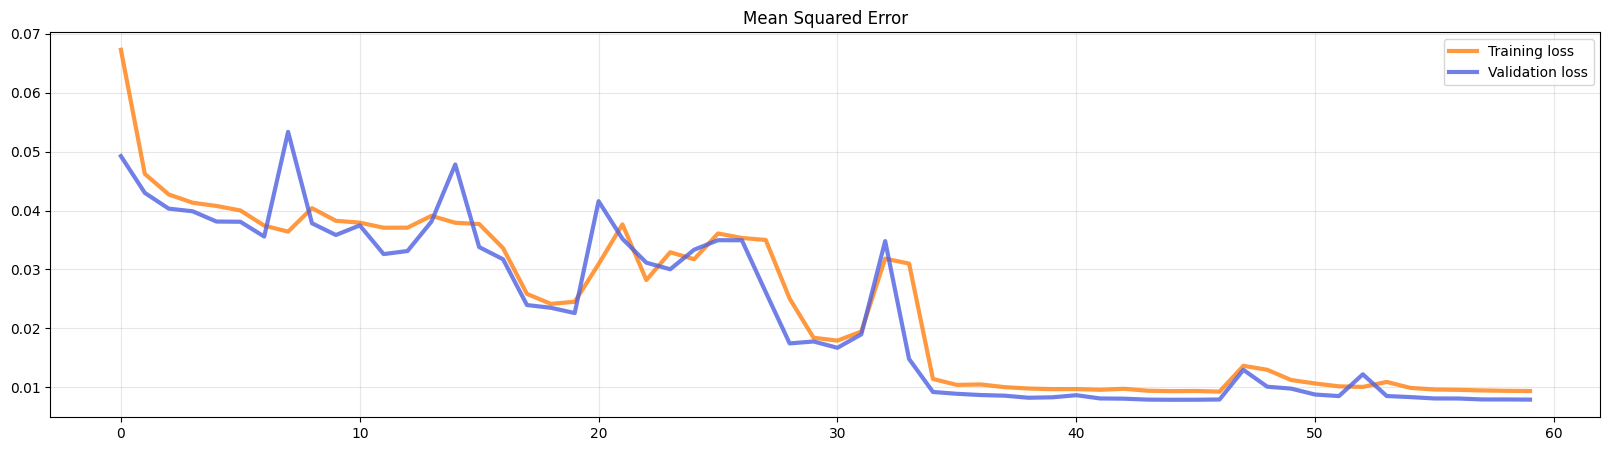

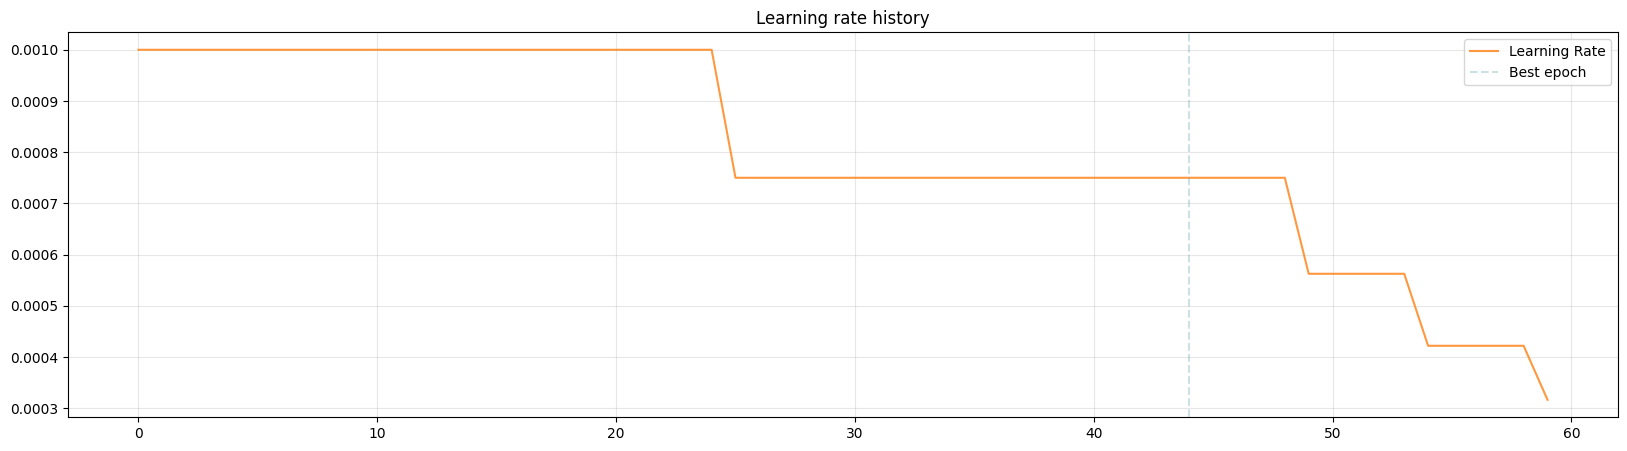

In [ ]:
plot_training(history)

In [ ]:
test_model(X_test, y_test, model_to_test=model)

Predictions shape: (20197, 18, 1)
Mean Squared Error: 0.007380941417068243
Mean Absolute Error: 0.04729531705379486


In [ ]:
end_experiment(experiment)

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/albertosandri/anndl-ts-forecasting/56d4eb0dba234fd386442c5efef8efd4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [780]          : (0.00792290735989809, 0.1689966470003128)
COMET INFO:     epoch_duration [60]       : (10.907101546999911, 18.744668776999788)
COMET INFO:     loss [60]                 : (0.009244497865438461, 0.06729630380868912)
COMET INFO:     lr [60]                   : (0.0003164062509313226, 0.0010000000474974513)
COMET INFO:     val_loss [60]             : (0.007858454249799252, 0.05335550382733345)
COMET INFO:     validate_

In [ ]:
model.save(model_name)

In [ ]:
del model

In [ ]:
model = tfk.models.load_model(model_name)

In [ ]:
def inspect_prediction(X, y, pred, telescope):

    pred = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),y],axis=1)

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        plt.plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        plt.plot(np.arange(len(X[0,:,i])-1, len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        plt.plot(np.arange(len(X[0,:,i])-1, len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        plt.set_title(col)
        plt.set_ylim(0,1)
    plt.show()

In [ ]:
inspect_prediction(X_test[0,:], y_test, predictions, 1, 18)

TypeError: ignored

### 2.3. Embedding model

In [ ]:
model_name = 'embed'
experiment = create_experiment(model_name)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/gdrive/MyDrive/[2023-2024] AN2DL/Homework 2' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/albertosandri/anndl-ts-forecasting/66b0154c82ad41e38ea9ae4399cb0f99



In [ ]:
training_hyperparameters = {
  'batch_size'        : 1024,
  'num_epochs'        : 200,
  'validation_split'  : 0.2,
  'test_split'        : 0.2,
  'ES_patience'       : 15,
  'R_LR_O_P_patience' : 5,
  'R_LR_O_P_factor'   : 0.75,
  'R_LR_O_P_min_lr'   : 1e-6,
  'window'            : 100,
  'stride'            : 25,
  'telescope'         : 18,
}
experiment.log_parameters(training_hyperparameters)

In [ ]:
network_hyperparameters = {
  'hidden_layer1'       : 'Bi-lstm',
  'hidden_layer1_units' : 128,
  'droput1'              : 0.2,
  #'hidden_layer1_activ' : 'relu',
  'hidden_layer2'       : 'bi-lstm',
  'hidden_layer2_units' : 64,
  'droput2'              : 0.2,
  'cropping'            : False,
  'dense_layer_units'   : 18,
  #'hidden_layer2_activ' : 'relu',
  #'conv1d_kernel_size'  : 3,
  #'conv1d_stride'       : 1,
}
experiment.log_parameters(network_hyperparameters)

In [ ]:
# Compute the indexes of the series longer than the window
valid_idxs = (valid_periods[:,1] - valid_periods[:,0]) > training_hyperparameters['window']

In [ ]:
# Split the series in train/val/test
train_samples = training_data[valid_idxs]
valid_periods_samples = valid_periods[valid_idxs]
categories_samples = categories[valid_idxs]

# Defining the number of samples in the test set and in the validation set
validation_size = training_hyperparameters['validation_split']
test_size = training_hyperparameters['test_split']

#train_samples = train_samples.reshape(train_samples.shape[0], train_samples.shape[1], 1)

# Split data into train_val and test sets
X_train_val, X_test, valid_periods_train_val, valid_periods_test, categories_train_val, categories_test = train_test_split(train_samples, valid_periods_samples, categories_samples, random_state=seed, test_size=test_size)

# Further split train_val into train and validation sets
X_train, X_val, valid_periods_train, valid_periods_val, categories_train, categories_val = train_test_split(X_train_val, valid_periods_train_val, categories_train_val, random_state=seed, test_size=validation_size)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (20853, 2776)
X_val shape: (5214, 2776)
X_test shape: (6517, 2776)


In [ ]:
# Create the datasets
X_train, y_train, categories_ohe_train = create_dataset_with_category_encoding(X_train, valid_periods_train, categories_train, training_hyperparameters['window'], training_hyperparameters['stride'], training_hyperparameters['telescope'])
X_val, y_val, categories_ohe_val = create_dataset_with_category_encoding(X_val, valid_periods_val, categories_val, training_hyperparameters['window'], training_hyperparameters['stride'], training_hyperparameters['telescope'])
X_test, y_test, categories_ohe_test = create_dataset_with_category_encoding(X_test, valid_periods_test, categories_test, training_hyperparameters['window'], training_hyperparameters['stride'], training_hyperparameters['telescope'])

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Creating Dataset: 100%|██████████| 6517/6517 [00:00<00:00, 45521.17it/s]


X_train shape: (111509, 100), y_train shape: (111509, 18)
X_val shape: (27504, 100), y_val shape: (27504, 18)
X_test shape: (35011, 100), y_test shape: (35011, 18)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
category_shape = categories_ohe_train.shape[1:]

input_shape, output_shape, category_shape

((1, 100, 1), (18, 1), (6,))

In [ ]:
# embed 4
def build_embedding_net(input_shape, output_shape, category_shape):
    # Define input shapes for time series data and one-hot encoded categories
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    input_category = tfkl.Input(shape=category_shape)

    # Bidirectional LSTM layers
    x = tfkl.Bidirectional(tfkl.LSTM(64))(input_layer)
    #x = tfkl.Dropout(0.3)(x)
    #x = tfkl.Bidirectional(tfkl.LSTM(64))(x)
    x = tfkl.Dropout(0.2)(x)

    #x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    #x = tfkl.Dropout(0.3)(x)
    #x = tfkl.Bidirectional(tfkl.LSTM(64))(x)
    #x = tfkl.Dropout(0.2)(x)
    #x = tfkl.Dense(64)(x)
    #x = tfkl.BatchNormalization()(x)
    #x = tfkl.ReLU()(x)
    #x = tfkl.Dropout(0.2)(x)
    # Dense layer for one-hot encoded categories
    #dense_category = tfkl.Dense(32, activation='relu')(input_category)

    dense_category = tfkl.Dense(32, activation='relu')(input_category)

    # Concatenate LSTM output and dense layer output
    concatenated = tfkl.Concatenate()([x, dense_category])

    output_layer = tfkl.Dense(output_shape[0])(concatenated)

    # Define the model with multiple inputs
    model = tfk.Model(inputs=[input_layer, input_category], outputs=output_layer, name='model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

    # Return the model
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 1, 100, 1)]          0         []                            
                                                                                                  
 conv_lstm1d_2 (ConvLSTM1D)  (None, 98, 64)               50176     ['input_layer[0][0]']         
                                                                                                  
 flatten_1 (Flatten)         (None, 6272)                 0         ['conv_lstm1d_2[0][0]']       
                                                                                                  
 dropout_2 (Dropout)         (None, 6272)                 0         ['flatten_1[0][0]']           
                                                                                              

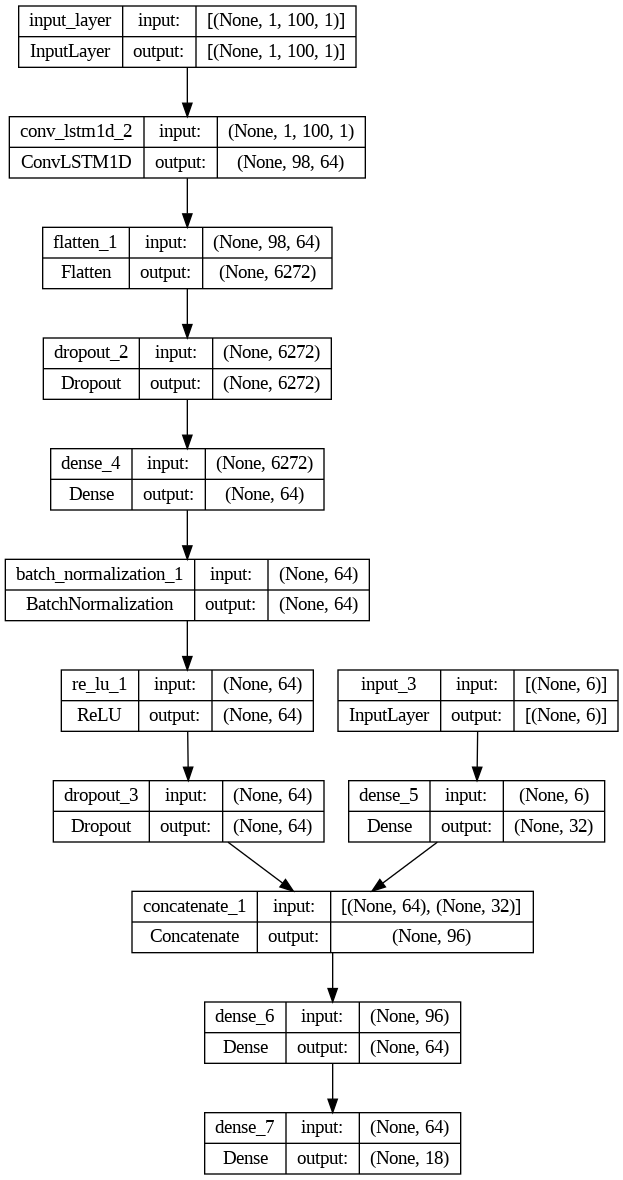

In [ ]:
model = build_embedding_net(input_shape, output_shape, category_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Define the callbacks
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=training_hyperparameters['ES_patience'], restore_best_weights=True)
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=training_hyperparameters['R_LR_O_P_patience'], factor=training_hyperparameters['R_LR_O_P_factor'], mode='min', min_lr=training_hyperparameters['R_LR_O_P_min_lr'])

# Train the model
history = model.fit(
    x = [X_train, categories_ohe_train],
    y = y_train,
    batch_size = training_hyperparameters['batch_size'],
    epochs = training_hyperparameters['num_epochs'],
    validation_data = ([X_val, categories_ohe_val], y_val),
    callbacks = [early_stopping, lr_scheduler],
).history

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/200
109/109 [==============================] - 16s 82ms/step - loss: 0.0532 - val_loss: 0.1018 - lr: 0.0010
Epoch 2/200
109/109 [==============================] - 5s 47ms/step - loss: 0.0138 - val_loss: 0.0676 - lr: 0.0010
Epoch 3/200
109/109 [==============================] - 5s 48ms/step - loss: 0.0124 - val_loss: 0.0541 - lr: 0.0010
Epoch 4/200
109/109 [==============================] - 5s 46ms/step - loss: 0.0118 - val_loss: 0.0397 - lr: 0.0010
Epoch 5/200
109/109 [==============================] - 5s 49ms/step - loss: 0.0115 - val_loss: 0.0269 - lr: 0.0010
Epoch 6/200
109/109 [==============================] - 5s 49ms/step - loss: 0.0112 - val_loss: 0.0154 - lr: 0.0010
Epoch 7/200
109/109 [==============================] - 5s 48ms/step - loss: 0.0109 - val_loss: 0.0132 - lr: 0.0010
Epoch 8/200
109/109 [==============================] - 5s 48ms/step - loss: 0.0108 - val_loss: 0.0099 - lr: 0.0010
Epoch 9/200
109/109 [==============================] - 5s 49ms/step - loss: 0.0

In [ ]:
plot_training(history)

In [ ]:
model.save(model_name)

In [ ]:
test_model([X_test, categories_ohe_test], y_test, model_to_test=model)

Predictions shape: (35011, 18)
Mean Squared Error: 0.008701499551534653
Mean Absolute Error: 0.06277498602867126


In [ ]:
test_model([X_test, categories_ohe_test], y_test, model_to_test=model, telescope=9)

Predictions shape: (35011, 9)
Mean Squared Error: 0.006051966920495033
Mean Absolute Error: 0.05134984478354454


In [ ]:
end_experiment(experiment)

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/albertosandri/anndl-ts-forecasting/c2d49772f63e4e30a851d50a4ac16372
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [4775]          : (0.006609419360756874, 0.3095996081829071)
COMET INFO:     epoch_duration [108]       : (8.490385357999912, 14.93205556599969)
COMET INFO:     loss [108]                 : (0.008217496797442436, 0.02267281897366047)
COMET INFO:     lr [108]                   : (3.167635077261366e-05, 0.0010000000474974513)
COMET INFO:     val_loss [108]             : (0.008674364537000656, 0.014416350983083248)
COMET INFO:     vali

In [ ]:
del model

### 2.4. NBeats

In [ ]:
experiment = create_experiment(experiment_name = 'nbeats-3H-6stack-512hu-8thetasdim')

In [ ]:
def smape_loss(y_true, y_pred):
    """
    sMAPE loss as defined in "Appendix A" of
    http://www.forecastingprinciples.com/files/pdf/Makridakia-The%20M3%20Competition.pdf
    :return: Loss value
    """
    # mask=tf.where(y_true,1.,0.)
    mask = tf.cast(y_true, tf.bool)
    mask = tf.cast(mask, tf.float32)
    sym_sum = tf.abs(y_true) + tf.abs(y_pred)
    condition = tf.cast(sym_sum, tf.bool)
    weights = tf.where(condition, 1. / (sym_sum + 1e-8), 0.0)
    return 200 * tnp.nanmean(tf.abs(y_pred - y_true) * weights * mask)

class NBeatsNet:
    GENERIC_BLOCK = 'generic'

    _BACKCAST = 'backcast'
    _FORECAST = 'forecast'

    def __init__(self,
                 input_dim=1,
                 output_dim=1,
                 exo_dim=0,
                 backcast_length=10,
                 forecast_length=1,
                 stack_types=(GENERIC_BLOCK, GENERIC_BLOCK),
                 nb_blocks_per_stack=3,
                 thetas_dim=(4, 8),
                 share_weights_in_stack=False,
                 hidden_layer_units=256,
                 dropout_rate=0.0,
                 nb_harmonics=None):

        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.thetas_dim = thetas_dim
        self.units = hidden_layer_units
        self.dropout_rate = dropout_rate
        self.share_weights_in_stack = share_weights_in_stack
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.exo_dim = exo_dim
        self.input_shape = (self.backcast_length, self.input_dim)
        self.exo_shape = (self.backcast_length, self.exo_dim)
        self.output_shape = (self.forecast_length, self.output_dim)
        self.weights = {}
        self.nb_harmonics = nb_harmonics
        self._gen_intermediate_outputs = False
        self._intermediary_outputs = []
        assert len(self.stack_types) == len(self.thetas_dim)

        x = tfk.Input(shape=self.input_shape, name='input_variable')
        x_ = {}
        for k in range(self.input_dim):
            x_[k] = tfkl.Lambda(lambda z: z[..., k])(x)
        e_ = {}
        if self.has_exog():
            e = Input(shape=self.exo_shape, name='exos_variables')
            for k in range(self.exo_dim):
                e_[k] = tfkl.Lambda(lambda z: z[..., k])(e)
        else:
            e = None
        y_ = {}

        for stack_id in range(len(self.stack_types)):
            stack_type = self.stack_types[stack_id]
            nb_poly = self.thetas_dim[stack_id]
            for block_id in range(self.nb_blocks_per_stack):
                backcast, forecast = self.create_block(x_, e_, stack_id, block_id, stack_type, nb_poly)
                for k in range(self.input_dim):
                    x_[k] = tfkl.Subtract()([x_[k], backcast[k]])
                    layer_name = f'stack_{stack_id}-{stack_type.title()}Block_{block_id}'
                    if self.input_dim >= 1:
                        layer_name += f'_Dim_{k}'
                    # rename.
                    forecast[k] = tfkl.Lambda(function=lambda _x: _x, name=layer_name)(forecast[k])
                    if stack_id == 0 and block_id == 0:
                        y_[k] = forecast[k]
                    else:
                        y_[k] = tfkl.Add()([y_[k], forecast[k]])

        for k in range(self.input_dim):
            y_[k] = tfkl.Reshape(target_shape=(self.forecast_length, 1))(y_[k])
            x_[k] = tfkl.Reshape(target_shape=(self.backcast_length, 1))(x_[k])
        if self.input_dim > 1:
            y_ = tfkl.Concatenate()([y_[ll] for ll in range(self.input_dim)])
            x_ = tfkl.Concatenate()([x_[ll] for ll in range(self.input_dim)])
        else:
            y_ = y_[0]
            x_ = x_[0]

        if self.input_dim != self.output_dim:
            y_ = tfkl.Dense(self.output_dim, activation='linear', name='reg_y')(y_)
            x_ = tfkl.Dense(self.output_dim, activation='linear', name='reg_x')(x_)

        inputs_x = [x, e] if self.has_exog() else x
        n_beats_forecast = tfk.Model(inputs_x, y_, name=self._FORECAST)
        n_beats_backcast = tfk.Model(inputs_x, x_, name=self._BACKCAST)

        self.models = {model.name: model for model in [n_beats_backcast, n_beats_forecast]}
        self.cast_type = self._FORECAST

    def get_generic_and_interpretable_outputs(self):
        g_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' in a['layer'].lower()])
        i_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' not in a['layer'].lower()])
        outputs = {o['layer']: o['value'][0] for o in self._intermediary_outputs}
        return g_pred, i_pred, outputs

    def has_exog(self):
        # exo/exog is short for 'exogenous variable', i.e. any input
        # features other than the target time-series itself.
        return self.exo_dim > 0

    @staticmethod
    def name():
        return 'NBeatsKeras'

    @staticmethod
    def load(filepath, custom_objects=None, compile=True):
        return tfk.models.load_model(filepath, custom_objects, compile)

    def _r(self, layer_with_weights, stack_id):
        # mechanism to restore weights when block share the same weights.
        # only useful when share_weights_in_stack=True.
        if self.share_weights_in_stack:
            layer_name = layer_with_weights.name.split('/')[-1]
            try:
                reused_weights = self.weights[stack_id][layer_name]
                return reused_weights
            except KeyError:
                pass
            if stack_id not in self.weights:
                self.weights[stack_id] = {}
            self.weights[stack_id][layer_name] = layer_with_weights
        return layer_with_weights

    def disable_intermediate_outputs(self):
        self._gen_intermediate_outputs = False

    def enable_intermediate_outputs(self):
        self._gen_intermediate_outputs = True

    def create_block(self, x, e, stack_id, block_id, stack_type, nb_poly):
        # register weights (useful when share_weights_in_stack=True)
        def reg(layer):
            return self._r(layer, stack_id)

        # update name (useful when share_weights_in_stack=True)
        def n(layer_name):
            return '/'.join([str(stack_id), str(block_id), stack_type, layer_name])

        backcast_ = {}
        forecast_ = {}
        d1 = reg(tfkl.Dense(self.units, activation='relu', name=n('d1')))
        d1_drop = tfkl.Dropout(self.dropout_rate, name=n('d1_dropout'))
        d2 = reg(tfkl.Dense(self.units, activation='relu', name=n('d2')))
        d2_drop = tfkl.Dropout(self.dropout_rate, name=n('d2_dropout'))
        d3 = reg(tfkl.Dense(self.units, activation='relu', name=n('d3')))
        d3_drop = tfkl.Dropout(self.dropout_rate, name=n('d3_dropout'))
        d4 = reg(tfkl.Dense(self.units, activation='relu', name=n('d4')))
        d4_drop = tfkl.Dropout(self.dropout_rate, name=n('d4_dropout'))

        theta_b = reg(tfkl.Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_b')))
        theta_f = reg(tfkl.Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f')))
        backcast = reg(tfkl.Dense(self.backcast_length, activation='linear', name=n('backcast')))
        forecast = reg(tfkl.Dense(self.forecast_length, activation='linear', name=n('forecast')))

        for k in range(self.input_dim):
            if self.has_exog():
                d0 = tfkl.Concatenate()([x[k]] + [e[ll] for ll in range(self.exo_dim)])
            else:
                d0 = x[k]
            d1_ = d1(d0)
            d1_ = d1_drop(d1_)
            d2_ = d2(d1_)
            d2_ = d2_drop(d2_)
            d3_ = d3(d2_)
            d3_ = d3_drop(d3_)
            d4_ = d4(d3_)
            d4_ = d4_drop(d4_)
            theta_f_ = theta_f(d4_)
            theta_b_ = theta_b(d4_)
            backcast_[k] = backcast(theta_b_)
            forecast_[k] = forecast(theta_f_)

        return backcast_, forecast_

    def __getattr__(self, name):
        attr = getattr(self.models[self._FORECAST], name)

        if not callable(attr):
            return attr

        def wrapper(*args, **kwargs):
            cast_type = self._FORECAST
            if attr.__name__ == 'predict' and 'return_backcast' in kwargs and kwargs['return_backcast']:
                del kwargs['return_backcast']
                cast_type = self._BACKCAST

            if attr.__name__ == 'predict' and self._gen_intermediate_outputs:
                import keract
                outputs = keract.get_activations(model=self, x=args)
                self._intermediary_outputs = [
                    {'layer': a, 'value': b} for a, b in outputs.items() if str(a).startswith('stack_')
                ]
            return getattr(self.models[cast_type], attr.__name__)(*args, **kwargs)

        return wrapper


def linear_space(backcast_length, forecast_length, is_forecast=True):
    horizon = forecast_length if is_forecast else backcast_length
    return K.arange(0, horizon) / horizon


def seasonality_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.get_shape().as_list()[-1]
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    s1 = K.stack([K.cos(2 * np.pi * i * t) for i in range(p1)])
    s2 = K.stack([K.sin(2 * np.pi * i * t) for i in range(p2)])
    if p == 1:
        s = s2
    else:
        s = K.concatenate([s1, s2], axis=0)
    s = K.cast(s, np.float32)
    return K.dot(thetas, s)


def trend_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.shape[-1]
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    t = K.transpose(K.stack([t ** i for i in range(p)]))
    t = K.cast(t, np.float32)
    return K.dot(thetas, K.transpose(t))

In [ ]:
dataset_hyperparam = {
    'test_size_percentage' : 0.3,
    'valid_size_percentage' : 0.5,
    'window' : 54,
    'telescope' : 18,
    'stride' : 9
}
training_data_filtered = training_data[valid_periods[:,1]-valid_periods[:,0] > dataset_hyperparam['window']]
intervals_filtered = valid_periods[valid_periods[:,1]-valid_periods[:,0] > dataset_hyperparam['window']]
categories_filtered = categories[valid_periods[:,1]-valid_periods[:,0] > dataset_hyperparam['window']]

experiment.log_parameters(dataset_hyperparam)

test_size_percentage = dataset_hyperparam['test_size_percentage']
window = dataset_hyperparam['window']
telescope = dataset_hyperparam['telescope']
stride = dataset_hyperparam['stride']

X_train_raw, X_valid_test_raw, categories_train, categories_valid_test, valid_periods_train, valid_periods_valid_test = train_test_split(training_data_filtered, categories_filtered, intervals_filtered, test_size = dataset_hyperparam['test_size_percentage'], stratify=categories_filtered)
X_valid_raw, X_test_raw, categories_valid, categories_test, valid_periods_valid, valid_periods_test = train_test_split(X_valid_test_raw, categories_valid_test, valid_periods_valid_test, test_size = dataset_hyperparam['valid_size_percentage'], stratify=categories_valid_test)
X_train, y_train = create_dataset(X_train_raw, valid_periods_train, dataset_hyperparam['window'], dataset_hyperparam['stride'], dataset_hyperparam['telescope'])
X_valid, y_valid = create_dataset(X_valid_raw, valid_periods_valid, dataset_hyperparam['window'], dataset_hyperparam['stride'], dataset_hyperparam['telescope'])
X_test, y_test = create_dataset(X_test_raw, valid_periods_test, window, stride, telescope)

input_shape, output_shape = X_train.shape[1:], y_train.shape[1:]

In [ ]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape, input_shape, output_shape

#### 2.4.1. NBeats Hyperparameters search with Keras Tuner

In [ ]:
def build_nbeats(hp):
    num_stacks = 6# hp.Int("stacks", min_value=6, max_value=10, step=2)
    network_hyperparams = {
        'input_dim' : 1,
        'output_dim' : 1,
        'exo_dim' : 0,
        'backcast_length' : window,
        'forecast_length' : telescope,
        'stack_types' : (NBeatsNet.GENERIC_BLOCK,) * num_stacks,
        'nb_blocks_per_stack' : 3,
        'thetas_dim' : (hp.Choice('hidden_layer_units', [4, 8]),) * num_stacks,
        'share_weights_in_stack' : False,
        'hidden_layer_units' : 512, # hp.Choice('hidden_layer_units', [256, 512]),
        'dropout_rate' : 0.0,
        'nb_harmonics' : None
    }

    nbeats = NBeatsNet(
        input_dim = network_hyperparams['input_dim'],
        output_dim = network_hyperparams['output_dim'],
        exo_dim = network_hyperparams['exo_dim'],
        backcast_length = network_hyperparams['backcast_length'],
        forecast_length = network_hyperparams['forecast_length'],
        stack_types = network_hyperparams['stack_types'],
        nb_blocks_per_stack = network_hyperparams['nb_blocks_per_stack'],
        thetas_dim = network_hyperparams['thetas_dim'],
        share_weights_in_stack = network_hyperparams['share_weights_in_stack'],
        hidden_layer_units = network_hyperparams['hidden_layer_units'],
        dropout_rate = network_hyperparams['dropout_rate'],
        nb_harmonics = network_hyperparams['nb_harmonics'],
    )
    model = tfk.models.Model(inputs=nbeats.inputs, outputs=nbeats.outputs)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_nbeats,
    objective="val_loss",
    max_trials=2,
    executions_per_trial=2,
    overwrite=True,
)

In [ ]:
tuner.search(X_train, y_train, epochs=20, batch_size=4096, validation_data=(X_valid, y_valid))

In [ ]:
tuner.results_summary()

#### 2.4.2. NBeats training

In [ ]:
network_hyperparams = {
    'input_dim' : 1,
    'output_dim' : 1,
    'exo_dim' : 0,
    'backcast_length' : window,
    'forecast_length' : telescope,
    'stack_types' : (NBeatsNet.GENERIC_BLOCK,) * 6,
    'nb_blocks_per_stack' : 3,
    'thetas_dim' : (8,) * 6,
    'share_weights_in_stack' : False,
    'hidden_layer_units' : 512,
    'dropout_rate' : 0.0,
    'nb_harmonics' : None
}
experiment.log_parameters(network_hyperparams)

nbeats = NBeatsNet(
    input_dim = network_hyperparams['input_dim'],
    output_dim = network_hyperparams['output_dim'],
    exo_dim = network_hyperparams['exo_dim'],
    backcast_length = network_hyperparams['backcast_length'],
    forecast_length = network_hyperparams['forecast_length'],
    stack_types = network_hyperparams['stack_types'],
    nb_blocks_per_stack = network_hyperparams['nb_blocks_per_stack'],
    thetas_dim = network_hyperparams['thetas_dim'],
    share_weights_in_stack = network_hyperparams['share_weights_in_stack'],
    hidden_layer_units = network_hyperparams['hidden_layer_units'],
    dropout_rate = network_hyperparams['dropout_rate'],
    nb_harmonics = network_hyperparams['nb_harmonics'],
)

nbeats.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

In [ ]:
# Train the model
history = nbeats.fit(
    x = X_train,
    y = y_train,
    batch_size = 4096,
    epochs = 200,
    validation_data=(X_valid, y_valid),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.99, min_lr=1e-5)
    ]
).history

In [ ]:
# Predict the test set using the model
predictions = nbeats.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
nbeats.save('models/nbeats-3H-6s-512hu')
end_experiment(experiment)
del nbeats

### Avengers Ensembled (Ensembles)